# importar librerias

In [ ]:
from torch.utils.data import Dataset, DataLoader
import fastai
from fastai.data.block import DataBlock,TransformBlock
from fastai.data.transforms import  RandomSplitter
from fastai.vision.data import ImageBlock, MaskBlock
from fastai.vision.core import TensorImage,TensorMask

In [ ]:
from functools import partial
from fastai.vision.all import get_files

In [ ]:
import fastai.vision.all  as fv

In [ ]:
from fastai.vision.all import *

from torchvision.models import *

from torch import nn

In [ ]:
from path import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
from numpy import ndarray

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch

In [ ]:
torch.cuda.is_available()

True

# Importar datos

In [ ]:
# Checking files
path = Path('/home/gomosak/Conafor')
imgs_path = path/'npy_data'
lbls_path = path/'npy_masks'

print(f'Checking number of files - images:{len([f for f in imgs_path.iterdir()])}\
      masks:{len([f for f in lbls_path.iterdir()])}')


# Checking file shapes

Checking number of files - images:34      masks:34


In [ ]:
img_path_1 = sorted([f for f in imgs_path.iterdir()], key = lambda x: int(x.stem))
msk_path_1 = sorted([f for f in lbls_path.iterdir()], key = lambda x: int(x.stem))

In [ ]:
img_path = img_path_1[9]
img_path

Path('/home/gomosak/Conafor/npy_data/9.npy')

In [ ]:
msk_path = msk_path_1[9]
msk_path

Path('/home/gomosak/Conafor/npy_masks/9.npy')

In [ ]:
img = np.load(str(img_path))
msk = np.load(str(msk_path))

print(f'Checking shapes - image: {img.shape} mask: {msk.shape}')

# Plotting a sample
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img.transpose((1, 2, 0))[..., :3]*3.0)
ax[1].imshow(msk)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Checking shapes - image: (6, 1041, 950) mask: (1041, 950)


In [ ]:
np.unique(msk)

array([1., 2., 3., 4., 5., 6.], dtype=float32)

# creacion de dataloadesr

In [ ]:
def open_npy(fn, chnls=None, cls=torch.Tensor):
    im = torch.from_numpy(np.load(str(fn))).type(torch.float32)
    if chnls is not None: im = im[chnls]
    return cls(im)

class MSTensorImage(TensorImage):

    def __init__(self, x, chnls_first=False):
        self.chnls_first = chnls_first

    @classmethod
    def create(cls, data:(Path), chnls=None, chnls_first=True):
        #if isinstance(data, Path) or isinstance(data, str):
        #if str(data).endswith('npy'):
        im = open_npy(fn=data, chnls=chnls, cls=torch.Tensor)
        return cls(im, chnls_first=chnls_first)


    def show(self, chnls=[3, 2, 1], bright=1., ctx=None):

        if img.ndim > 2:
            visu_img = self[..., chnls] if not self.chnls_first else self.permute([1, 2, 0])[..., chnls]
        else:
            visu_img = self

        visu_img = visu_img.squeeze()

        visu_img *= bright
        visu_img = np.where(visu_img > 1, 1, visu_img)
        visu_img = np.where(visu_img < 0, 0, visu_img)

        plt.imshow(visu_img) if ctx is None else ctx.imshow(visu_img)

        return ctx

    def __repr__(self):

        return (f'MSTensorImage: {self.shape}')

    def toNumpy(self, force = True):
        return self.numpy(force = force)

In [ ]:
def open_npy(fn, chnls=None, cls=torch.Tensor):
    im = torch.from_numpy(np.load(str(fn))).type(torch.float32)
    if chnls is not None: im = im[chnls]
    return cls(im)

In [ ]:
img = MSTensorImage.create(img_path)#img_path,chnls = [0,1,2])
print(img.shape)

torch.Size([6, 1041, 950])


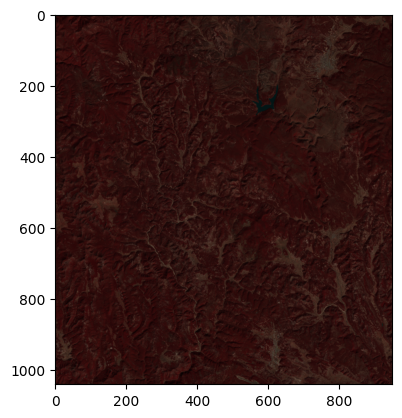

In [ ]:
img.show()

MSTensorImage: torch.Size([6, 1041, 950])


<Axes: >

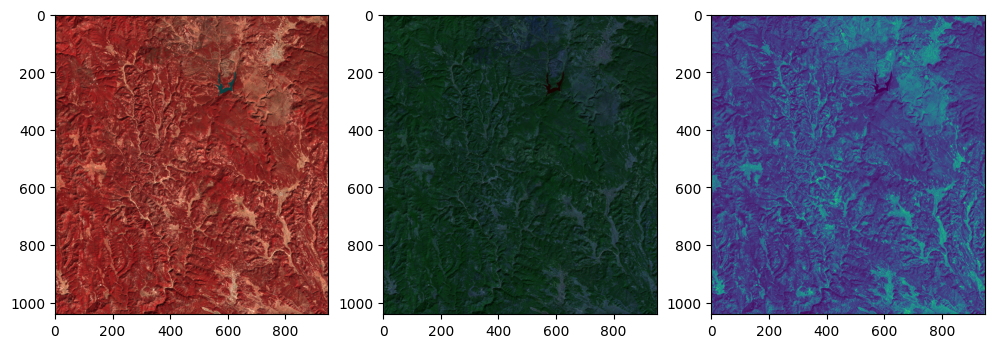

In [ ]:
img = MSTensorImage.create(img_path)
print(img)

_, ax = plt.subplots(1, 3, figsize=(12, 4))
img.show(bright=3., ctx=ax[0])
img.show(chnls=[2, 3, 5], ctx=ax[1])
img.show(chnls=[5], ctx=ax[2])

torch.Size([1041, 950])


<Axes: >

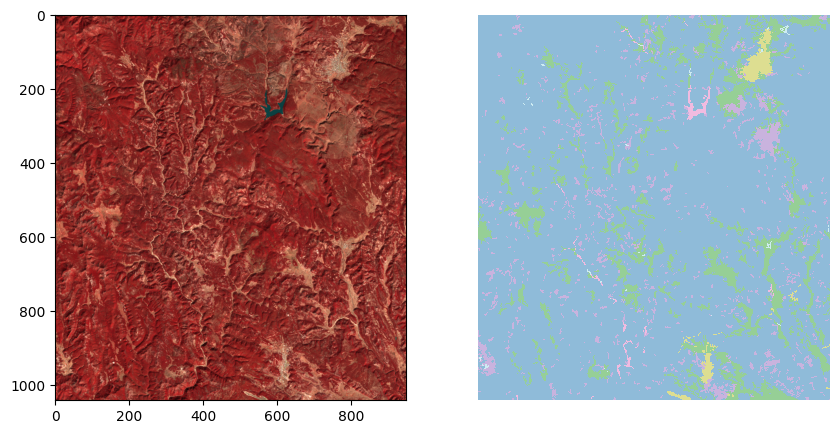

In [ ]:
mask = TensorMask(open_npy(msk_path))
print(mask.shape)

_, ax = plt.subplots(1, 2, figsize=(10, 5))
img.show(bright=3., ctx=ax[0])
mask.show(ctx=ax[1])

In [ ]:
mask

TensorMask([[1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            ...,
            [1., 1., 1.,  ..., 3., 3., 3.],
            [1., 1., 1.,  ..., 3., 3., 3.],
            [1., 1., 1.,  ..., 1., 1., 1.]])

In [ ]:
def open_npy_mask(fn, chnls=None, cls=torch.Tensor):
    name = '/home/gomosak/Conafor/npy_masks/'+fn.name
    im = torch.from_numpy(np.load(str(name)))#.type(torch.float32)
    if chnls is not None: im = im[chnls]
    return cls(im)

db = DataBlock(blocks=(TransformBlock(type_tfms= partial(MSTensorImage.create, chnls_first=True)),
                       TransformBlock(type_tfms= partial(open_npy_mask,cls=TensorMask))),
                                      #item_tfms= AddMaskCodes(codes=['clear', 'water', 'shadow','a','b','c']),

               get_items = partial(get_files, extensions='.npy'),
               #get_y = lambda x: print(x,'\n ++++++++++++++++++++++++++++++++++++++') ,
               splitter  = RandomSplitter(valid_pct=0.1)
              )

In [ ]:
def load_data(path, img_size, batch_size):
	tfms = fv.aug_transforms(size = img_size,
                            max_rotate = 360,
                            flip_vert = True
                            )

	data = fv.DataBlock(blocks = (TransformBlock(type_tfms= partial(MSTensorImage.create, chnls_first=True)),
			    	TransformBlock(type_tfms= partial(open_npy_mask,cls=TensorMask))),
                                   item_tfms= AddMaskCodes(codes=['clear', 'water', 'shadow','a','b','c','aba']),
			    	get_items = fv.get_files,
			    	splitter = fv.RandomSplitter(valid_pct=0.1),
			    	#item_tfms = fv.Resize(int(1.5*img_size)),
			    	batch_tfms = tfms,
                       )
	return data.dataloaders(path, bs = batch_size)

In [ ]:
db = load_data(imgs_path,(1056, 960),1)

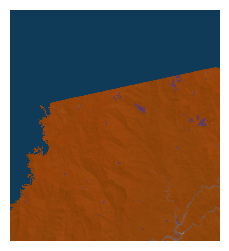

In [ ]:
db.show_batch()

# modelo manual

In [ ]:
xb,yb = next(iter(db.train))
xb.shape, yb.shape

(torch.Size([1, 6, 1056, 960]), torch.Size([1, 1056, 960]))

In [ ]:
model = nn.Sequential(
	nn.Conv2d(6,16, kernel_size = 3, padding=1),
	nn.BatchNorm2d(16),
	nn.ReLU(),
	nn.Conv2d(16,16, kernel_size = 3, padding=1),
	nn.BatchNorm2d(16),
	nn.ReLU(),
	nn.Conv2d(16,16, kernel_size = 3, padding=1),
	nn.BatchNorm2d(16),
	nn.ReLU(),
	nn.Conv2d(16,16, kernel_size = 3, padding=1),
	nn.BatchNorm2d(16),
	nn.ReLU(),
	nn.Conv2d(16,7, kernel_size = 3, padding=1),
).cuda()

In [ ]:
def seg_accuracy(yp,y):
	return fv.accuracy(yp,y,axis = 1)

In [ ]:
x,y = db.one_batch()

In [ ]:
ypm = model(x)

In [ ]:
resnet18??

Signature:
resnet18(
    *,
    weights: Optional[torchvision.models.resnet.ResNet18_Weights] = None,
    progress: bool = True,
    **kwargs: Any,
) -> torchvision.models.resnet.ResNet
Source:   
@register_model()
@handle_legacy_interface(weights=("pretrained", ResNet18_Weights.IMAGENET1K_V1))
def resnet18(*, weights: Optional[ResNet18_Weights] = None, progress: bool = True, **kwargs: Any) -> ResNet:
    """ResNet-18 from `Deep Residual Learning for Image Recognition <https://arxiv.org/abs/1512.03385>`__.

    Args:
        weights (:class:`~torchvision.models.ResNet18_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.ResNet18_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the
            download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.mo

In [ ]:
def loss(yp,y):

    y_long = y.long()  # Convert y to long
    return F.cross_entropy(yp,y_long)


In [ ]:
def loss(yp, y):
    y_long = y.long()  # Convert y to long
    return F.cross_entropy(yp,y_long)

In [ ]:
torch.unique(y)

TensorMask([0., 1., 2., 3., 4., 5., 6.], device='cuda:0')

In [ ]:
learn = Learner(db, model, loss_func = loss,opt_func = fv.ranger,metrics = seg_accuracy )

learn = unet_learner(db, model)

In [ ]:
learn.summary()

Sequential (Input shape: 10 x 6 x 312 x 285)
Layer (type)         Output Shape         Param #    Trainable 
                     10 x 16 x 312 x 285 
Conv2d                                    880        True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                                    2320       True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                                    2320       True      
BatchNorm2d                               32         True      
ReLU                                                           
Conv2d                                    2320       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
    

SuggestedLRs(valley=0.00363078061491251)

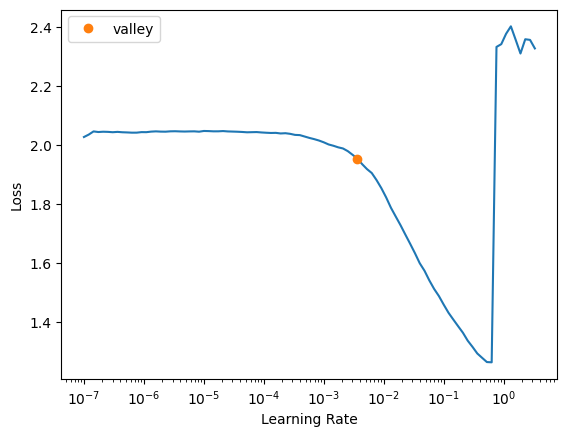

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10)

In [ ]:
learn.fit_one_cycle(10)

TypeError: Invalid shape (7, 312, 285) for image data

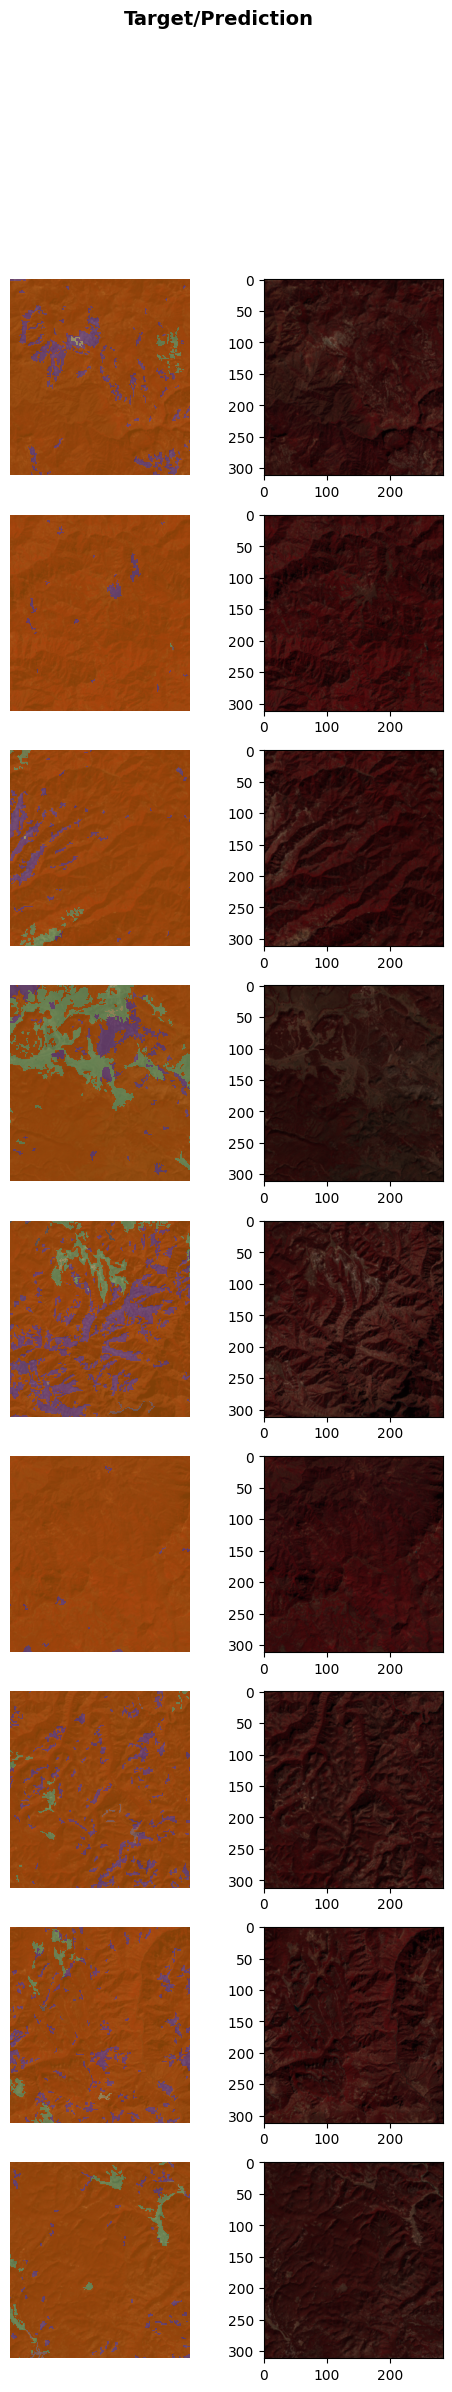

In [ ]:
learn.show_results()

# Resnet adaptation

In [ ]:
# Load pre-trained ResNet18 model
resnet18 = models.resnet18(weights=True)

In [ ]:
out_channels,kernel_size,stride,padding,bias,new_first_layer

(64,
 (7, 7),
 (2, 2),
 (3, 3),
 None,
 Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))

In [ ]:
# Parameters of the original first conv layer
original_first_layer = resnet18.conv1
out_channels = original_first_layer.out_channels
kernel_size = original_first_layer.kernel_size
stride = original_first_layer.stride
padding = original_first_layer.padding
bias = original_first_layer.bias

# Create a new conv layer with 6 input channels
new_first_layer = nn.Conv2d(6, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias)

# Replace the first conv layer with the new one
resnet18.conv1 = new_first_layer

In [ ]:
from torchvision.models import resnet18
import torch.nn as nn

def create_custom_resnet18_model(pretrained=True, n_in=6):
    # Create the usual pretrained model
    model = resnet18(pretrained=pretrained)
    # Adjust the first convolutional layer
    original_first_layer = model.conv1
    new_first_layer = nn.Conv2d(n_in,
                                original_first_layer.out_channels,
                                kernel_size=original_first_layer.kernel_size,
                                stride=original_first_layer.stride,
                                padding=original_first_layer.padding,
                                bias=original_first_layer.bias)
    # Copying pretrained weights for the first 3 channels to new first layer
    with torch.no_grad():
        new_first_layer.weight[:, :3] = original_first_layer.weight.clone()
        # Initialize the next 3 channels to the same weights as the first three for simplicity
        new_first_layer.weight[:, 3:6] = original_first_layer.weight.clone()[:, :3]
    # Replace the first layer
    model.conv1 = new_first_layer
    return model

from fastai.vision.learner import unet_learner
from fastai.vision.models.unet import DynamicUnet
from fastai.data.block import DataBlock
from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock, MaskBlock
from pathlib import Path
from fastai.losses import CrossEntropyLossFlat
from fastai.metrics import Dice, JaccardCoeff

# Assuming 'db' is your DataBlock or Dataloaders ready for 6-channelled imagery and corresponding segmentation maps
custom_resnet18 = create_custom_resnet18_model(pretrained=True, n_in=6)



In [ ]:
import torch
import torch.nn as nn


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels,
            intermediate_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False,
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(
            image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((312 , 285))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        print(x.shape)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)

In [ ]:
def ResNet50(img_channel=6, num_classes=7):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
net = ResNet50(img_channel=6, num_classes=7).to(device)
#net

In [ ]:
torch.randn(5, 6, 312 , 285).shape

torch.Size([5, 6, 312, 285])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
yp = net(torch.randn(2, 6, 312 , 285).to(device))

torch.Size([2, 182108160])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x182108160 and 2048x7)

In [ ]:
def test():
    BATCH_SIZE = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNet101(img_channel=3, num_classes=7).to(device)
    y = net(torch.randn(BATCH_SIZE, 3, 224, 224)).to(device)
    assert y.size() == torch.Size([BATCH_SIZE, 1000])
    print(y.size())

In [ ]:
def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def test():
    BATCH_SIZE = 4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNet101(img_channel=3, num_classes=1000).to(device)
    y = net(torch.randn(BATCH_SIZE, 3, 224, 224)).to(device)
    assert y.size() == torch.Size([BATCH_SIZE, 1000])
    print(y.size())


if __name__ == "__main__":
    test()

In [ ]:
tst = create_unet_model(models.resnet18,7,(312 , 285), True, n_in=1)

In [ ]:
tst

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [ ]:
learn = Learner(db, tst, loss_func = loss,opt_func = fv.ranger,metrics = seg_accuracy )

In [ ]:
# Now create the unet learner with your `custom_resnet18` as the encoder of the U-Net
learn = unet_learner(db, tst)


TypeError: SequentialEx.forward() got an unexpected keyword argument 'pretrained'

In [ ]:
learn.summary()

RuntimeError: Given groups=1, weight of size [64, 1, 7, 7], expected input[1, 6, 312, 285] to have 1 channels, but got 6 channels instead

In [ ]:
learn.lr_find()

RuntimeError: Given groups=1, weight of size [64, 1, 7, 7], expected input[10, 6, 312, 285] to have 1 channels, but got 6 channels instead

# otros modelos

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.5,               # dropout ratio, default is None
    activation='sigmoid',      # activation function, default is None
    classes=7,                 # define number of output labels
)
model = smp.UnetPlusPlus('resnext101_32x4d',in_channels=6, classes=7, aux_params=aux_params).to('cuda')
#mask, label = model(x)

KeyError: "Wrong pretrained weights `imagenet` for encoder `resnext101_32x4d`. Available options are: ['ssl', 'swsl']"

In [ ]:
model = smp.UnetPlusPlus(
    encoder_name="resnext101_32x4d",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="swsl",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=6,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=7,                      # model output channels (number of classes in your dataset)
).to('cuda')

In [ ]:
model

NameError: name 'model' is not defined

In [ ]:
model = smp.FPN('resnet34', in_channels=6, classes = 7)


In [ ]:
torch.save(model, 'complete_model.pth')

In [ ]:
mask.shape

torch.Size([1041, 950])

In [ ]:
model = torch.load('complete_model.pth')
model = model.to('cuda')

# entrenamiento

In [ ]:
def loss(yp, y):
    y_long = y.long()  # Convert y to long
    return F.cross_entropy(yp,y)

In [ ]:
def seg_accuracy(yp,y):
	return fv.accuracy(yp,y,axis = 1)

In [ ]:
learn = Learner(db, model, loss_func = loss, opt_func = fv.ranger,metrics = seg_accuracy)


In [ ]:
learn.summary()

UnetPlusPlus (Input shape: 1 x 6 x 1056 x 960)
Layer (type)         Output Shape         Param #    Trainable 
                     1 x 64 x 528 x 480  
Conv2d                                    18816      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     1 x 64 x 264 x 240  
MaxPool2d                                                      
____________________________________________________________________________
                     1 x 128 x 264 x 240 
Conv2d                                    8192       True      
BatchNorm2d                               256        True      
Conv2d                                    4608       True      
BatchNorm2d                               256        True      
____________________________________________________________________________
                    

SuggestedLRs(valley=0.019054606556892395)

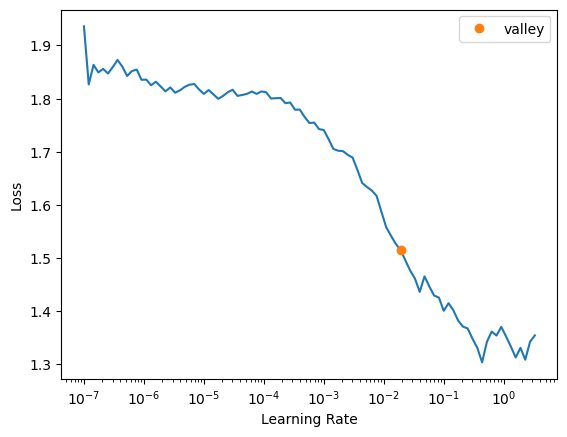

In [ ]:
learn.lr_find()

In [ ]:
7e-3

0.007

In [ ]:
learn.fit_one_cycle(7,lr_max = 1e-2)

In [ ]:
learn.fit_one_cycle(5,lr_max = 2e-3)

In [ ]:
torch.save(model.state_dict(), 'model_weights_resnext101_32x4d_UnetPlusPlus.pth')

In [ ]:
model_loaded = smp.UnetPlusPlus()  # Replace MyModel with your model class

In [ ]:
model_loaded.load_state_dict(torch.load('model_weights.pth'))
model_loaded.eval()  # Set the model to evaluation mode

RuntimeError: Error(s) in loading state_dict for UnetPlusPlus:
	Unexpected key(s) in state_dict: "encoder.layer1.0.conv3.weight", "encoder.layer1.0.bn3.weight", "encoder.layer1.0.bn3.bias", "encoder.layer1.0.bn3.running_mean", "encoder.layer1.0.bn3.running_var", "encoder.layer1.0.bn3.num_batches_tracked", "encoder.layer1.0.downsample.0.weight", "encoder.layer1.0.downsample.1.weight", "encoder.layer1.0.downsample.1.bias", "encoder.layer1.0.downsample.1.running_mean", "encoder.layer1.0.downsample.1.running_var", "encoder.layer1.0.downsample.1.num_batches_tracked", "encoder.layer1.1.conv3.weight", "encoder.layer1.1.bn3.weight", "encoder.layer1.1.bn3.bias", "encoder.layer1.1.bn3.running_mean", "encoder.layer1.1.bn3.running_var", "encoder.layer1.1.bn3.num_batches_tracked", "encoder.layer1.2.conv3.weight", "encoder.layer1.2.bn3.weight", "encoder.layer1.2.bn3.bias", "encoder.layer1.2.bn3.running_mean", "encoder.layer1.2.bn3.running_var", "encoder.layer1.2.bn3.num_batches_tracked", "encoder.layer2.4.conv1.weight", "encoder.layer2.4.bn1.weight", "encoder.layer2.4.bn1.bias", "encoder.layer2.4.bn1.running_mean", "encoder.layer2.4.bn1.running_var", "encoder.layer2.4.bn1.num_batches_tracked", "encoder.layer2.4.conv2.weight", "encoder.layer2.4.bn2.weight", "encoder.layer2.4.bn2.bias", "encoder.layer2.4.bn2.running_mean", "encoder.layer2.4.bn2.running_var", "encoder.layer2.4.bn2.num_batches_tracked", "encoder.layer2.4.conv3.weight", "encoder.layer2.4.bn3.weight", "encoder.layer2.4.bn3.bias", "encoder.layer2.4.bn3.running_mean", "encoder.layer2.4.bn3.running_var", "encoder.layer2.4.bn3.num_batches_tracked", "encoder.layer2.5.conv1.weight", "encoder.layer2.5.bn1.weight", "encoder.layer2.5.bn1.bias", "encoder.layer2.5.bn1.running_mean", "encoder.layer2.5.bn1.running_var", "encoder.layer2.5.bn1.num_batches_tracked", "encoder.layer2.5.conv2.weight", "encoder.layer2.5.bn2.weight", "encoder.layer2.5.bn2.bias", "encoder.layer2.5.bn2.running_mean", "encoder.layer2.5.bn2.running_var", "encoder.layer2.5.bn2.num_batches_tracked", "encoder.layer2.5.conv3.weight", "encoder.layer2.5.bn3.weight", "encoder.layer2.5.bn3.bias", "encoder.layer2.5.bn3.running_mean", "encoder.layer2.5.bn3.running_var", "encoder.layer2.5.bn3.num_batches_tracked", "encoder.layer2.6.conv1.weight", "encoder.layer2.6.bn1.weight", "encoder.layer2.6.bn1.bias", "encoder.layer2.6.bn1.running_mean", "encoder.layer2.6.bn1.running_var", "encoder.layer2.6.bn1.num_batches_tracked", "encoder.layer2.6.conv2.weight", "encoder.layer2.6.bn2.weight", "encoder.layer2.6.bn2.bias", "encoder.layer2.6.bn2.running_mean", "encoder.layer2.6.bn2.running_var", "encoder.layer2.6.bn2.num_batches_tracked", "encoder.layer2.6.conv3.weight", "encoder.layer2.6.bn3.weight", "encoder.layer2.6.bn3.bias", "encoder.layer2.6.bn3.running_mean", "encoder.layer2.6.bn3.running_var", "encoder.layer2.6.bn3.num_batches_tracked", "encoder.layer2.7.conv1.weight", "encoder.layer2.7.bn1.weight", "encoder.layer2.7.bn1.bias", "encoder.layer2.7.bn1.running_mean", "encoder.layer2.7.bn1.running_var", "encoder.layer2.7.bn1.num_batches_tracked", "encoder.layer2.7.conv2.weight", "encoder.layer2.7.bn2.weight", "encoder.layer2.7.bn2.bias", "encoder.layer2.7.bn2.running_mean", "encoder.layer2.7.bn2.running_var", "encoder.layer2.7.bn2.num_batches_tracked", "encoder.layer2.7.conv3.weight", "encoder.layer2.7.bn3.weight", "encoder.layer2.7.bn3.bias", "encoder.layer2.7.bn3.running_mean", "encoder.layer2.7.bn3.running_var", "encoder.layer2.7.bn3.num_batches_tracked", "encoder.layer2.0.conv3.weight", "encoder.layer2.0.bn3.weight", "encoder.layer2.0.bn3.bias", "encoder.layer2.0.bn3.running_mean", "encoder.layer2.0.bn3.running_var", "encoder.layer2.0.bn3.num_batches_tracked", "encoder.layer2.1.conv3.weight", "encoder.layer2.1.bn3.weight", "encoder.layer2.1.bn3.bias", "encoder.layer2.1.bn3.running_mean", "encoder.layer2.1.bn3.running_var", "encoder.layer2.1.bn3.num_batches_tracked", "encoder.layer2.2.conv3.weight", "encoder.layer2.2.bn3.weight", "encoder.layer2.2.bn3.bias", "encoder.layer2.2.bn3.running_mean", "encoder.layer2.2.bn3.running_var", "encoder.layer2.2.bn3.num_batches_tracked", "encoder.layer2.3.conv3.weight", "encoder.layer2.3.bn3.weight", "encoder.layer2.3.bn3.bias", "encoder.layer2.3.bn3.running_mean", "encoder.layer2.3.bn3.running_var", "encoder.layer2.3.bn3.num_batches_tracked", "encoder.layer3.6.conv1.weight", "encoder.layer3.6.bn1.weight", "encoder.layer3.6.bn1.bias", "encoder.layer3.6.bn1.running_mean", "encoder.layer3.6.bn1.running_var", "encoder.layer3.6.bn1.num_batches_tracked", "encoder.layer3.6.conv2.weight", "encoder.layer3.6.bn2.weight", "encoder.layer3.6.bn2.bias", "encoder.layer3.6.bn2.running_mean", "encoder.layer3.6.bn2.running_var", "encoder.layer3.6.bn2.num_batches_tracked", "encoder.layer3.6.conv3.weight", "encoder.layer3.6.bn3.weight", "encoder.layer3.6.bn3.bias", "encoder.layer3.6.bn3.running_mean", "encoder.layer3.6.bn3.running_var", "encoder.layer3.6.bn3.num_batches_tracked", "encoder.layer3.7.conv1.weight", "encoder.layer3.7.bn1.weight", "encoder.layer3.7.bn1.bias", "encoder.layer3.7.bn1.running_mean", "encoder.layer3.7.bn1.running_var", "encoder.layer3.7.bn1.num_batches_tracked", "encoder.layer3.7.conv2.weight", "encoder.layer3.7.bn2.weight", "encoder.layer3.7.bn2.bias", "encoder.layer3.7.bn2.running_mean", "encoder.layer3.7.bn2.running_var", "encoder.layer3.7.bn2.num_batches_tracked", "encoder.layer3.7.conv3.weight", "encoder.layer3.7.bn3.weight", "encoder.layer3.7.bn3.bias", "encoder.layer3.7.bn3.running_mean", "encoder.layer3.7.bn3.running_var", "encoder.layer3.7.bn3.num_batches_tracked", "encoder.layer3.8.conv1.weight", "encoder.layer3.8.bn1.weight", "encoder.layer3.8.bn1.bias", "encoder.layer3.8.bn1.running_mean", "encoder.layer3.8.bn1.running_var", "encoder.layer3.8.bn1.num_batches_tracked", "encoder.layer3.8.conv2.weight", "encoder.layer3.8.bn2.weight", "encoder.layer3.8.bn2.bias", "encoder.layer3.8.bn2.running_mean", "encoder.layer3.8.bn2.running_var", "encoder.layer3.8.bn2.num_batches_tracked", "encoder.layer3.8.conv3.weight", "encoder.layer3.8.bn3.weight", "encoder.layer3.8.bn3.bias", "encoder.layer3.8.bn3.running_mean", "encoder.layer3.8.bn3.running_var", "encoder.layer3.8.bn3.num_batches_tracked", "encoder.layer3.9.conv1.weight", "encoder.layer3.9.bn1.weight", "encoder.layer3.9.bn1.bias", "encoder.layer3.9.bn1.running_mean", "encoder.layer3.9.bn1.running_var", "encoder.layer3.9.bn1.num_batches_tracked", "encoder.layer3.9.conv2.weight", "encoder.layer3.9.bn2.weight", "encoder.layer3.9.bn2.bias", "encoder.layer3.9.bn2.running_mean", "encoder.layer3.9.bn2.running_var", "encoder.layer3.9.bn2.num_batches_tracked", "encoder.layer3.9.conv3.weight", "encoder.layer3.9.bn3.weight", "encoder.layer3.9.bn3.bias", "encoder.layer3.9.bn3.running_mean", "encoder.layer3.9.bn3.running_var", "encoder.layer3.9.bn3.num_batches_tracked", "encoder.layer3.10.conv1.weight", "encoder.layer3.10.bn1.weight", "encoder.layer3.10.bn1.bias", "encoder.layer3.10.bn1.running_mean", "encoder.layer3.10.bn1.running_var", "encoder.layer3.10.bn1.num_batches_tracked", "encoder.layer3.10.conv2.weight", "encoder.layer3.10.bn2.weight", "encoder.layer3.10.bn2.bias", "encoder.layer3.10.bn2.running_mean", "encoder.layer3.10.bn2.running_var", "encoder.layer3.10.bn2.num_batches_tracked", "encoder.layer3.10.conv3.weight", "encoder.layer3.10.bn3.weight", "encoder.layer3.10.bn3.bias", "encoder.layer3.10.bn3.running_mean", "encoder.layer3.10.bn3.running_var", "encoder.layer3.10.bn3.num_batches_tracked", "encoder.layer3.11.conv1.weight", "encoder.layer3.11.bn1.weight", "encoder.layer3.11.bn1.bias", "encoder.layer3.11.bn1.running_mean", "encoder.layer3.11.bn1.running_var", "encoder.layer3.11.bn1.num_batches_tracked", "encoder.layer3.11.conv2.weight", "encoder.layer3.11.bn2.weight", "encoder.layer3.11.bn2.bias", "encoder.layer3.11.bn2.running_mean", "encoder.layer3.11.bn2.running_var", "encoder.layer3.11.bn2.num_batches_tracked", "encoder.layer3.11.conv3.weight", "encoder.layer3.11.bn3.weight", "encoder.layer3.11.bn3.bias", "encoder.layer3.11.bn3.running_mean", "encoder.layer3.11.bn3.running_var", "encoder.layer3.11.bn3.num_batches_tracked", "encoder.layer3.12.conv1.weight", "encoder.layer3.12.bn1.weight", "encoder.layer3.12.bn1.bias", "encoder.layer3.12.bn1.running_mean", "encoder.layer3.12.bn1.running_var", "encoder.layer3.12.bn1.num_batches_tracked", "encoder.layer3.12.conv2.weight", "encoder.layer3.12.bn2.weight", "encoder.layer3.12.bn2.bias", "encoder.layer3.12.bn2.running_mean", "encoder.layer3.12.bn2.running_var", "encoder.layer3.12.bn2.num_batches_tracked", "encoder.layer3.12.conv3.weight", "encoder.layer3.12.bn3.weight", "encoder.layer3.12.bn3.bias", "encoder.layer3.12.bn3.running_mean", "encoder.layer3.12.bn3.running_var", "encoder.layer3.12.bn3.num_batches_tracked", "encoder.layer3.13.conv1.weight", "encoder.layer3.13.bn1.weight", "encoder.layer3.13.bn1.bias", "encoder.layer3.13.bn1.running_mean", "encoder.layer3.13.bn1.running_var", "encoder.layer3.13.bn1.num_batches_tracked", "encoder.layer3.13.conv2.weight", "encoder.layer3.13.bn2.weight", "encoder.layer3.13.bn2.bias", "encoder.layer3.13.bn2.running_mean", "encoder.layer3.13.bn2.running_var", "encoder.layer3.13.bn2.num_batches_tracked", "encoder.layer3.13.conv3.weight", "encoder.layer3.13.bn3.weight", "encoder.layer3.13.bn3.bias", "encoder.layer3.13.bn3.running_mean", "encoder.layer3.13.bn3.running_var", "encoder.layer3.13.bn3.num_batches_tracked", "encoder.layer3.14.conv1.weight", "encoder.layer3.14.bn1.weight", "encoder.layer3.14.bn1.bias", "encoder.layer3.14.bn1.running_mean", "encoder.layer3.14.bn1.running_var", "encoder.layer3.14.bn1.num_batches_tracked", "encoder.layer3.14.conv2.weight", "encoder.layer3.14.bn2.weight", "encoder.layer3.14.bn2.bias", "encoder.layer3.14.bn2.running_mean", "encoder.layer3.14.bn2.running_var", "encoder.layer3.14.bn2.num_batches_tracked", "encoder.layer3.14.conv3.weight", "encoder.layer3.14.bn3.weight", "encoder.layer3.14.bn3.bias", "encoder.layer3.14.bn3.running_mean", "encoder.layer3.14.bn3.running_var", "encoder.layer3.14.bn3.num_batches_tracked", "encoder.layer3.15.conv1.weight", "encoder.layer3.15.bn1.weight", "encoder.layer3.15.bn1.bias", "encoder.layer3.15.bn1.running_mean", "encoder.layer3.15.bn1.running_var", "encoder.layer3.15.bn1.num_batches_tracked", "encoder.layer3.15.conv2.weight", "encoder.layer3.15.bn2.weight", "encoder.layer3.15.bn2.bias", "encoder.layer3.15.bn2.running_mean", "encoder.layer3.15.bn2.running_var", "encoder.layer3.15.bn2.num_batches_tracked", "encoder.layer3.15.conv3.weight", "encoder.layer3.15.bn3.weight", "encoder.layer3.15.bn3.bias", "encoder.layer3.15.bn3.running_mean", "encoder.layer3.15.bn3.running_var", "encoder.layer3.15.bn3.num_batches_tracked", "encoder.layer3.16.conv1.weight", "encoder.layer3.16.bn1.weight", "encoder.layer3.16.bn1.bias", "encoder.layer3.16.bn1.running_mean", "encoder.layer3.16.bn1.running_var", "encoder.layer3.16.bn1.num_batches_tracked", "encoder.layer3.16.conv2.weight", "encoder.layer3.16.bn2.weight", "encoder.layer3.16.bn2.bias", "encoder.layer3.16.bn2.running_mean", "encoder.layer3.16.bn2.running_var", "encoder.layer3.16.bn2.num_batches_tracked", "encoder.layer3.16.conv3.weight", "encoder.layer3.16.bn3.weight", "encoder.layer3.16.bn3.bias", "encoder.layer3.16.bn3.running_mean", "encoder.layer3.16.bn3.running_var", "encoder.layer3.16.bn3.num_batches_tracked", "encoder.layer3.17.conv1.weight", "encoder.layer3.17.bn1.weight", "encoder.layer3.17.bn1.bias", "encoder.layer3.17.bn1.running_mean", "encoder.layer3.17.bn1.running_var", "encoder.layer3.17.bn1.num_batches_tracked", "encoder.layer3.17.conv2.weight", "encoder.layer3.17.bn2.weight", "encoder.layer3.17.bn2.bias", "encoder.layer3.17.bn2.running_mean", "encoder.layer3.17.bn2.running_var", "encoder.layer3.17.bn2.num_batches_tracked", "encoder.layer3.17.conv3.weight", "encoder.layer3.17.bn3.weight", "encoder.layer3.17.bn3.bias", "encoder.layer3.17.bn3.running_mean", "encoder.layer3.17.bn3.running_var", "encoder.layer3.17.bn3.num_batches_tracked", "encoder.layer3.18.conv1.weight", "encoder.layer3.18.bn1.weight", "encoder.layer3.18.bn1.bias", "encoder.layer3.18.bn1.running_mean", "encoder.layer3.18.bn1.running_var", "encoder.layer3.18.bn1.num_batches_tracked", "encoder.layer3.18.conv2.weight", "encoder.layer3.18.bn2.weight", "encoder.layer3.18.bn2.bias", "encoder.layer3.18.bn2.running_mean", "encoder.layer3.18.bn2.running_var", "encoder.layer3.18.bn2.num_batches_tracked", "encoder.layer3.18.conv3.weight", "encoder.layer3.18.bn3.weight", "encoder.layer3.18.bn3.bias", "encoder.layer3.18.bn3.running_mean", "encoder.layer3.18.bn3.running_var", "encoder.layer3.18.bn3.num_batches_tracked", "encoder.layer3.19.conv1.weight", "encoder.layer3.19.bn1.weight", "encoder.layer3.19.bn1.bias", "encoder.layer3.19.bn1.running_mean", "encoder.layer3.19.bn1.running_var", "encoder.layer3.19.bn1.num_batches_tracked", "encoder.layer3.19.conv2.weight", "encoder.layer3.19.bn2.weight", "encoder.layer3.19.bn2.bias", "encoder.layer3.19.bn2.running_mean", "encoder.layer3.19.bn2.running_var", "encoder.layer3.19.bn2.num_batches_tracked", "encoder.layer3.19.conv3.weight", "encoder.layer3.19.bn3.weight", "encoder.layer3.19.bn3.bias", "encoder.layer3.19.bn3.running_mean", "encoder.layer3.19.bn3.running_var", "encoder.layer3.19.bn3.num_batches_tracked", "encoder.layer3.20.conv1.weight", "encoder.layer3.20.bn1.weight", "encoder.layer3.20.bn1.bias", "encoder.layer3.20.bn1.running_mean", "encoder.layer3.20.bn1.running_var", "encoder.layer3.20.bn1.num_batches_tracked", "encoder.layer3.20.conv2.weight", "encoder.layer3.20.bn2.weight", "encoder.layer3.20.bn2.bias", "encoder.layer3.20.bn2.running_mean", "encoder.layer3.20.bn2.running_var", "encoder.layer3.20.bn2.num_batches_tracked", "encoder.layer3.20.conv3.weight", "encoder.layer3.20.bn3.weight", "encoder.layer3.20.bn3.bias", "encoder.layer3.20.bn3.running_mean", "encoder.layer3.20.bn3.running_var", "encoder.layer3.20.bn3.num_batches_tracked", "encoder.layer3.21.conv1.weight", "encoder.layer3.21.bn1.weight", "encoder.layer3.21.bn1.bias", "encoder.layer3.21.bn1.running_mean", "encoder.layer3.21.bn1.running_var", "encoder.layer3.21.bn1.num_batches_tracked", "encoder.layer3.21.conv2.weight", "encoder.layer3.21.bn2.weight", "encoder.layer3.21.bn2.bias", "encoder.layer3.21.bn2.running_mean", "encoder.layer3.21.bn2.running_var", "encoder.layer3.21.bn2.num_batches_tracked", "encoder.layer3.21.conv3.weight", "encoder.layer3.21.bn3.weight", "encoder.layer3.21.bn3.bias", "encoder.layer3.21.bn3.running_mean", "encoder.layer3.21.bn3.running_var", "encoder.layer3.21.bn3.num_batches_tracked", "encoder.layer3.22.conv1.weight", "encoder.layer3.22.bn1.weight", "encoder.layer3.22.bn1.bias", "encoder.layer3.22.bn1.running_mean", "encoder.layer3.22.bn1.running_var", "encoder.layer3.22.bn1.num_batches_tracked", "encoder.layer3.22.conv2.weight", "encoder.layer3.22.bn2.weight", "encoder.layer3.22.bn2.bias", "encoder.layer3.22.bn2.running_mean", "encoder.layer3.22.bn2.running_var", "encoder.layer3.22.bn2.num_batches_tracked", "encoder.layer3.22.conv3.weight", "encoder.layer3.22.bn3.weight", "encoder.layer3.22.bn3.bias", "encoder.layer3.22.bn3.running_mean", "encoder.layer3.22.bn3.running_var", "encoder.layer3.22.bn3.num_batches_tracked", "encoder.layer3.23.conv1.weight", "encoder.layer3.23.bn1.weight", "encoder.layer3.23.bn1.bias", "encoder.layer3.23.bn1.running_mean", "encoder.layer3.23.bn1.running_var", "encoder.layer3.23.bn1.num_batches_tracked", "encoder.layer3.23.conv2.weight", "encoder.layer3.23.bn2.weight", "encoder.layer3.23.bn2.bias", "encoder.layer3.23.bn2.running_mean", "encoder.layer3.23.bn2.running_var", "encoder.layer3.23.bn2.num_batches_tracked", "encoder.layer3.23.conv3.weight", "encoder.layer3.23.bn3.weight", "encoder.layer3.23.bn3.bias", "encoder.layer3.23.bn3.running_mean", "encoder.layer3.23.bn3.running_var", "encoder.layer3.23.bn3.num_batches_tracked", "encoder.layer3.24.conv1.weight", "encoder.layer3.24.bn1.weight", "encoder.layer3.24.bn1.bias", "encoder.layer3.24.bn1.running_mean", "encoder.layer3.24.bn1.running_var", "encoder.layer3.24.bn1.num_batches_tracked", "encoder.layer3.24.conv2.weight", "encoder.layer3.24.bn2.weight", "encoder.layer3.24.bn2.bias", "encoder.layer3.24.bn2.running_mean", "encoder.layer3.24.bn2.running_var", "encoder.layer3.24.bn2.num_batches_tracked", "encoder.layer3.24.conv3.weight", "encoder.layer3.24.bn3.weight", "encoder.layer3.24.bn3.bias", "encoder.layer3.24.bn3.running_mean", "encoder.layer3.24.bn3.running_var", "encoder.layer3.24.bn3.num_batches_tracked", "encoder.layer3.25.conv1.weight", "encoder.layer3.25.bn1.weight", "encoder.layer3.25.bn1.bias", "encoder.layer3.25.bn1.running_mean", "encoder.layer3.25.bn1.running_var", "encoder.layer3.25.bn1.num_batches_tracked", "encoder.layer3.25.conv2.weight", "encoder.layer3.25.bn2.weight", "encoder.layer3.25.bn2.bias", "encoder.layer3.25.bn2.running_mean", "encoder.layer3.25.bn2.running_var", "encoder.layer3.25.bn2.num_batches_tracked", "encoder.layer3.25.conv3.weight", "encoder.layer3.25.bn3.weight", "encoder.layer3.25.bn3.bias", "encoder.layer3.25.bn3.running_mean", "encoder.layer3.25.bn3.running_var", "encoder.layer3.25.bn3.num_batches_tracked", "encoder.layer3.26.conv1.weight", "encoder.layer3.26.bn1.weight", "encoder.layer3.26.bn1.bias", "encoder.layer3.26.bn1.running_mean", "encoder.layer3.26.bn1.running_var", "encoder.layer3.26.bn1.num_batches_tracked", "encoder.layer3.26.conv2.weight", "encoder.layer3.26.bn2.weight", "encoder.layer3.26.bn2.bias", "encoder.layer3.26.bn2.running_mean", "encoder.layer3.26.bn2.running_var", "encoder.layer3.26.bn2.num_batches_tracked", "encoder.layer3.26.conv3.weight", "encoder.layer3.26.bn3.weight", "encoder.layer3.26.bn3.bias", "encoder.layer3.26.bn3.running_mean", "encoder.layer3.26.bn3.running_var", "encoder.layer3.26.bn3.num_batches_tracked", "encoder.layer3.27.conv1.weight", "encoder.layer3.27.bn1.weight", "encoder.layer3.27.bn1.bias", "encoder.layer3.27.bn1.running_mean", "encoder.layer3.27.bn1.running_var", "encoder.layer3.27.bn1.num_batches_tracked", "encoder.layer3.27.conv2.weight", "encoder.layer3.27.bn2.weight", "encoder.layer3.27.bn2.bias", "encoder.layer3.27.bn2.running_mean", "encoder.layer3.27.bn2.running_var", "encoder.layer3.27.bn2.num_batches_tracked", "encoder.layer3.27.conv3.weight", "encoder.layer3.27.bn3.weight", "encoder.layer3.27.bn3.bias", "encoder.layer3.27.bn3.running_mean", "encoder.layer3.27.bn3.running_var", "encoder.layer3.27.bn3.num_batches_tracked", "encoder.layer3.28.conv1.weight", "encoder.layer3.28.bn1.weight", "encoder.layer3.28.bn1.bias", "encoder.layer3.28.bn1.running_mean", "encoder.layer3.28.bn1.running_var", "encoder.layer3.28.bn1.num_batches_tracked", "encoder.layer3.28.conv2.weight", "encoder.layer3.28.bn2.weight", "encoder.layer3.28.bn2.bias", "encoder.layer3.28.bn2.running_mean", "encoder.layer3.28.bn2.running_var", "encoder.layer3.28.bn2.num_batches_tracked", "encoder.layer3.28.conv3.weight", "encoder.layer3.28.bn3.weight", "encoder.layer3.28.bn3.bias", "encoder.layer3.28.bn3.running_mean", "encoder.layer3.28.bn3.running_var", "encoder.layer3.28.bn3.num_batches_tracked", "encoder.layer3.29.conv1.weight", "encoder.layer3.29.bn1.weight", "encoder.layer3.29.bn1.bias", "encoder.layer3.29.bn1.running_mean", "encoder.layer3.29.bn1.running_var", "encoder.layer3.29.bn1.num_batches_tracked", "encoder.layer3.29.conv2.weight", "encoder.layer3.29.bn2.weight", "encoder.layer3.29.bn2.bias", "encoder.layer3.29.bn2.running_mean", "encoder.layer3.29.bn2.running_var", "encoder.layer3.29.bn2.num_batches_tracked", "encoder.layer3.29.conv3.weight", "encoder.layer3.29.bn3.weight", "encoder.layer3.29.bn3.bias", "encoder.layer3.29.bn3.running_mean", "encoder.layer3.29.bn3.running_var", "encoder.layer3.29.bn3.num_batches_tracked", "encoder.layer3.30.conv1.weight", "encoder.layer3.30.bn1.weight", "encoder.layer3.30.bn1.bias", "encoder.layer3.30.bn1.running_mean", "encoder.layer3.30.bn1.running_var", "encoder.layer3.30.bn1.num_batches_tracked", "encoder.layer3.30.conv2.weight", "encoder.layer3.30.bn2.weight", "encoder.layer3.30.bn2.bias", "encoder.layer3.30.bn2.running_mean", "encoder.layer3.30.bn2.running_var", "encoder.layer3.30.bn2.num_batches_tracked", "encoder.layer3.30.conv3.weight", "encoder.layer3.30.bn3.weight", "encoder.layer3.30.bn3.bias", "encoder.layer3.30.bn3.running_mean", "encoder.layer3.30.bn3.running_var", "encoder.layer3.30.bn3.num_batches_tracked", "encoder.layer3.31.conv1.weight", "encoder.layer3.31.bn1.weight", "encoder.layer3.31.bn1.bias", "encoder.layer3.31.bn1.running_mean", "encoder.layer3.31.bn1.running_var", "encoder.layer3.31.bn1.num_batches_tracked", "encoder.layer3.31.conv2.weight", "encoder.layer3.31.bn2.weight", "encoder.layer3.31.bn2.bias", "encoder.layer3.31.bn2.running_mean", "encoder.layer3.31.bn2.running_var", "encoder.layer3.31.bn2.num_batches_tracked", "encoder.layer3.31.conv3.weight", "encoder.layer3.31.bn3.weight", "encoder.layer3.31.bn3.bias", "encoder.layer3.31.bn3.running_mean", "encoder.layer3.31.bn3.running_var", "encoder.layer3.31.bn3.num_batches_tracked", "encoder.layer3.32.conv1.weight", "encoder.layer3.32.bn1.weight", "encoder.layer3.32.bn1.bias", "encoder.layer3.32.bn1.running_mean", "encoder.layer3.32.bn1.running_var", "encoder.layer3.32.bn1.num_batches_tracked", "encoder.layer3.32.conv2.weight", "encoder.layer3.32.bn2.weight", "encoder.layer3.32.bn2.bias", "encoder.layer3.32.bn2.running_mean", "encoder.layer3.32.bn2.running_var", "encoder.layer3.32.bn2.num_batches_tracked", "encoder.layer3.32.conv3.weight", "encoder.layer3.32.bn3.weight", "encoder.layer3.32.bn3.bias", "encoder.layer3.32.bn3.running_mean", "encoder.layer3.32.bn3.running_var", "encoder.layer3.32.bn3.num_batches_tracked", "encoder.layer3.33.conv1.weight", "encoder.layer3.33.bn1.weight", "encoder.layer3.33.bn1.bias", "encoder.layer3.33.bn1.running_mean", "encoder.layer3.33.bn1.running_var", "encoder.layer3.33.bn1.num_batches_tracked", "encoder.layer3.33.conv2.weight", "encoder.layer3.33.bn2.weight", "encoder.layer3.33.bn2.bias", "encoder.layer3.33.bn2.running_mean", "encoder.layer3.33.bn2.running_var", "encoder.layer3.33.bn2.num_batches_tracked", "encoder.layer3.33.conv3.weight", "encoder.layer3.33.bn3.weight", "encoder.layer3.33.bn3.bias", "encoder.layer3.33.bn3.running_mean", "encoder.layer3.33.bn3.running_var", "encoder.layer3.33.bn3.num_batches_tracked", "encoder.layer3.34.conv1.weight", "encoder.layer3.34.bn1.weight", "encoder.layer3.34.bn1.bias", "encoder.layer3.34.bn1.running_mean", "encoder.layer3.34.bn1.running_var", "encoder.layer3.34.bn1.num_batches_tracked", "encoder.layer3.34.conv2.weight", "encoder.layer3.34.bn2.weight", "encoder.layer3.34.bn2.bias", "encoder.layer3.34.bn2.running_mean", "encoder.layer3.34.bn2.running_var", "encoder.layer3.34.bn2.num_batches_tracked", "encoder.layer3.34.conv3.weight", "encoder.layer3.34.bn3.weight", "encoder.layer3.34.bn3.bias", "encoder.layer3.34.bn3.running_mean", "encoder.layer3.34.bn3.running_var", "encoder.layer3.34.bn3.num_batches_tracked", "encoder.layer3.35.conv1.weight", "encoder.layer3.35.bn1.weight", "encoder.layer3.35.bn1.bias", "encoder.layer3.35.bn1.running_mean", "encoder.layer3.35.bn1.running_var", "encoder.layer3.35.bn1.num_batches_tracked", "encoder.layer3.35.conv2.weight", "encoder.layer3.35.bn2.weight", "encoder.layer3.35.bn2.bias", "encoder.layer3.35.bn2.running_mean", "encoder.layer3.35.bn2.running_var", "encoder.layer3.35.bn2.num_batches_tracked", "encoder.layer3.35.conv3.weight", "encoder.layer3.35.bn3.weight", "encoder.layer3.35.bn3.bias", "encoder.layer3.35.bn3.running_mean", "encoder.layer3.35.bn3.running_var", "encoder.layer3.35.bn3.num_batches_tracked", "encoder.layer3.0.conv3.weight", "encoder.layer3.0.bn3.weight", "encoder.layer3.0.bn3.bias", "encoder.layer3.0.bn3.running_mean", "encoder.layer3.0.bn3.running_var", "encoder.layer3.0.bn3.num_batches_tracked", "encoder.layer3.1.conv3.weight", "encoder.layer3.1.bn3.weight", "encoder.layer3.1.bn3.bias", "encoder.layer3.1.bn3.running_mean", "encoder.layer3.1.bn3.running_var", "encoder.layer3.1.bn3.num_batches_tracked", "encoder.layer3.2.conv3.weight", "encoder.layer3.2.bn3.weight", "encoder.layer3.2.bn3.bias", "encoder.layer3.2.bn3.running_mean", "encoder.layer3.2.bn3.running_var", "encoder.layer3.2.bn3.num_batches_tracked", "encoder.layer3.3.conv3.weight", "encoder.layer3.3.bn3.weight", "encoder.layer3.3.bn3.bias", "encoder.layer3.3.bn3.running_mean", "encoder.layer3.3.bn3.running_var", "encoder.layer3.3.bn3.num_batches_tracked", "encoder.layer3.4.conv3.weight", "encoder.layer3.4.bn3.weight", "encoder.layer3.4.bn3.bias", "encoder.layer3.4.bn3.running_mean", "encoder.layer3.4.bn3.running_var", "encoder.layer3.4.bn3.num_batches_tracked", "encoder.layer3.5.conv3.weight", "encoder.layer3.5.bn3.weight", "encoder.layer3.5.bn3.bias", "encoder.layer3.5.bn3.running_mean", "encoder.layer3.5.bn3.running_var", "encoder.layer3.5.bn3.num_batches_tracked", "encoder.layer4.0.conv3.weight", "encoder.layer4.0.bn3.weight", "encoder.layer4.0.bn3.bias", "encoder.layer4.0.bn3.running_mean", "encoder.layer4.0.bn3.running_var", "encoder.layer4.0.bn3.num_batches_tracked", "encoder.layer4.1.conv3.weight", "encoder.layer4.1.bn3.weight", "encoder.layer4.1.bn3.bias", "encoder.layer4.1.bn3.running_mean", "encoder.layer4.1.bn3.running_var", "encoder.layer4.1.bn3.num_batches_tracked", "encoder.layer4.2.conv3.weight", "encoder.layer4.2.bn3.weight", "encoder.layer4.2.bn3.bias", "encoder.layer4.2.bn3.running_mean", "encoder.layer4.2.bn3.running_var", "encoder.layer4.2.bn3.num_batches_tracked". 
	size mismatch for encoder.conv1.weight: copying a param with shape torch.Size([64, 6, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 3, 7, 7]).
	size mismatch for encoder.layer1.0.conv1.weight: copying a param with shape torch.Size([64, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for encoder.layer1.1.conv1.weight: copying a param with shape torch.Size([64, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for encoder.layer1.2.conv1.weight: copying a param with shape torch.Size([64, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for encoder.layer2.0.conv1.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 3, 3]).
	size mismatch for encoder.layer2.0.downsample.0.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 64, 1, 1]).
	size mismatch for encoder.layer2.0.downsample.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder.layer2.0.downsample.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder.layer2.0.downsample.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder.layer2.0.downsample.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder.layer2.1.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for encoder.layer2.2.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for encoder.layer2.3.conv1.weight: copying a param with shape torch.Size([128, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for encoder.layer3.0.conv1.weight: copying a param with shape torch.Size([256, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 3, 3]).
	size mismatch for encoder.layer3.0.downsample.0.weight: copying a param with shape torch.Size([1024, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 128, 1, 1]).
	size mismatch for encoder.layer3.0.downsample.1.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer3.0.downsample.1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer3.0.downsample.1.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer3.0.downsample.1.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.layer3.1.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for encoder.layer3.2.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for encoder.layer3.3.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for encoder.layer3.4.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for encoder.layer3.5.conv1.weight: copying a param with shape torch.Size([256, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 256, 3, 3]).
	size mismatch for encoder.layer4.0.conv1.weight: copying a param with shape torch.Size([512, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 3, 3]).
	size mismatch for encoder.layer4.0.downsample.0.weight: copying a param with shape torch.Size([2048, 1024, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for encoder.layer4.0.downsample.1.weight: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer4.0.downsample.1.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer4.0.downsample.1.running_mean: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer4.0.downsample.1.running_var: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.layer4.1.conv1.weight: copying a param with shape torch.Size([512, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for encoder.layer4.2.conv1.weight: copying a param with shape torch.Size([512, 2048, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).
	size mismatch for decoder.blocks.x_0_0.conv1.0.weight: copying a param with shape torch.Size([256, 3072, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 768, 3, 3]).
	size mismatch for decoder.blocks.x_0_1.conv1.0.weight: copying a param with shape torch.Size([128, 1280, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 512, 3, 3]).
	size mismatch for decoder.blocks.x_1_1.conv1.0.weight: copying a param with shape torch.Size([512, 1536, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 384, 3, 3]).
	size mismatch for decoder.blocks.x_1_1.conv1.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.blocks.x_1_1.conv1.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.blocks.x_1_1.conv1.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.blocks.x_1_1.conv1.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.blocks.x_1_1.conv2.0.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 128, 3, 3]).
	size mismatch for decoder.blocks.x_1_1.conv2.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.blocks.x_1_1.conv2.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.blocks.x_1_1.conv2.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.blocks.x_1_1.conv2.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.blocks.x_0_2.conv1.0.weight: copying a param with shape torch.Size([64, 896, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 320, 3, 3]).
	size mismatch for decoder.blocks.x_1_2.conv1.0.weight: copying a param with shape torch.Size([256, 1024, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 256, 3, 3]).
	size mismatch for decoder.blocks.x_1_2.conv1.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_1_2.conv1.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_1_2.conv1.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_1_2.conv1.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_1_2.conv2.0.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for decoder.blocks.x_1_2.conv2.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_1_2.conv2.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_1_2.conv2.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_1_2.conv2.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_2_2.conv1.0.weight: copying a param with shape torch.Size([256, 768, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 192, 3, 3]).
	size mismatch for decoder.blocks.x_2_2.conv1.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_2_2.conv1.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_2_2.conv1.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_2_2.conv1.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_2_2.conv2.0.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 3, 3]).
	size mismatch for decoder.blocks.x_2_2.conv2.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_2_2.conv2.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_2_2.conv2.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_2_2.conv2.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.blocks.x_1_3.conv1.0.weight: copying a param with shape torch.Size([64, 448, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 256, 3, 3]).
	size mismatch for decoder.blocks.x_2_3.conv1.0.weight: copying a param with shape torch.Size([64, 384, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 192, 3, 3]).
	size mismatch for decoder.blocks.x_3_3.conv1.0.weight: copying a param with shape torch.Size([64, 320, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 128, 3, 3]).
	size mismatch for segmentation_head.0.weight: copying a param with shape torch.Size([7, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 16, 3, 3]).
	size mismatch for segmentation_head.0.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([1]).

In [ ]:
db.valid_ds

(#3) [(MSTensorImage: torch.Size([6, 1041, 950]), TensorMask([[1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [4., 1., 1.,  ..., 1., 1., 1.],
            ...,
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.]])),(MSTensorImage: torch.Size([6, 1041, 950]), TensorMask([[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.]])),(MSTensorImage: torch.Size([6, 1041, 950]), TensorMask([[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.],
            [1., 1., 1.,  ..., 1., 1., 1.]]))]

In [ ]:
xb,yb = next(iter(db.train))
xb.shape, yb.shape

(torch.Size([1, 6, 1056, 960]), torch.Size([1, 1056, 960]))

In [ ]:
preds,targs = learn.get_preds(ds_idx = 0,dl=db)

In [ ]:
learn.predict()

TypeError: Learner.predict() missing 1 required positional argument: 'item'

In [ ]:
preds.shape

torch.Size([31, 7, 1056, 960])

In [ ]:
predicted = F.softmax(preds, dim=1).max(dim = 1)[1]

/tmp/ipykernel_35512/997564282.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(1, 2, figsize=(10, 5))


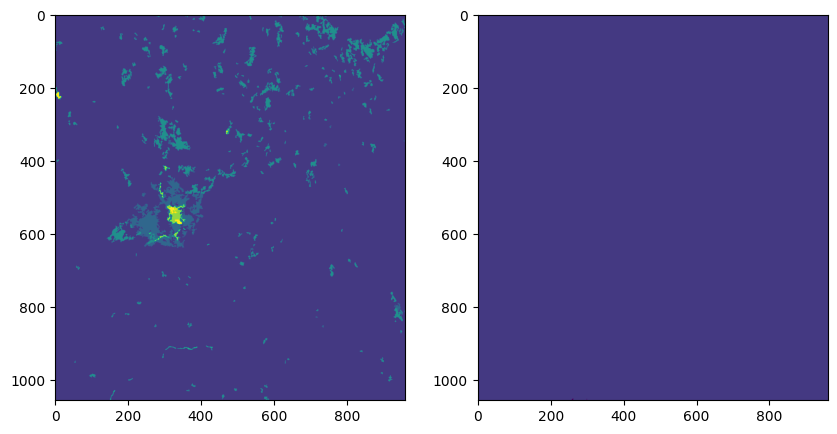

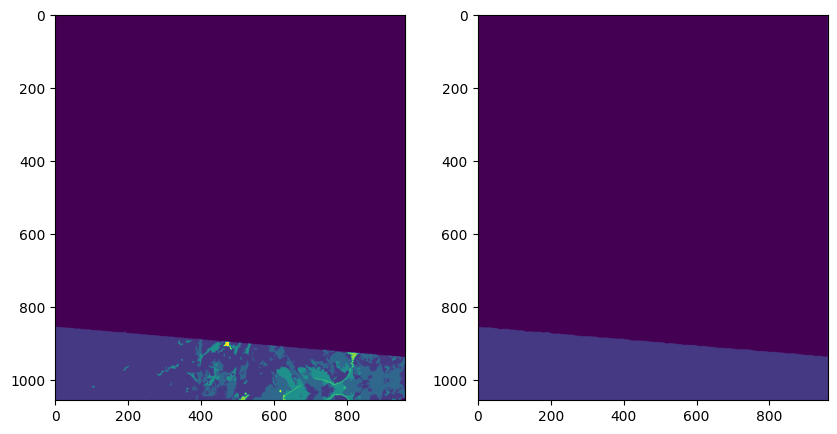

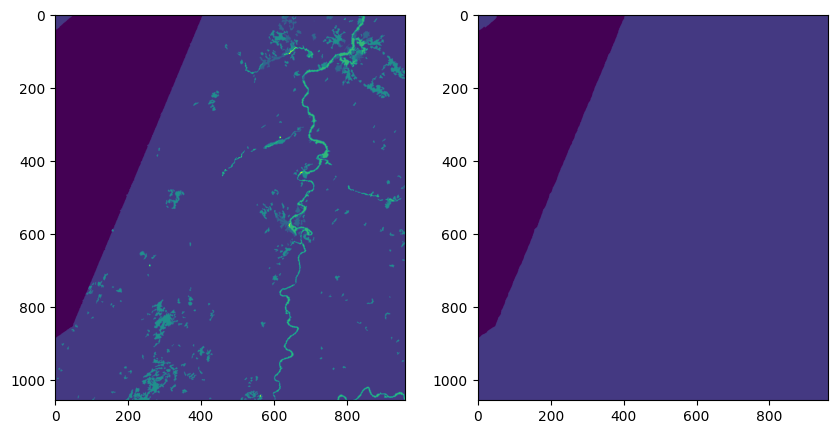

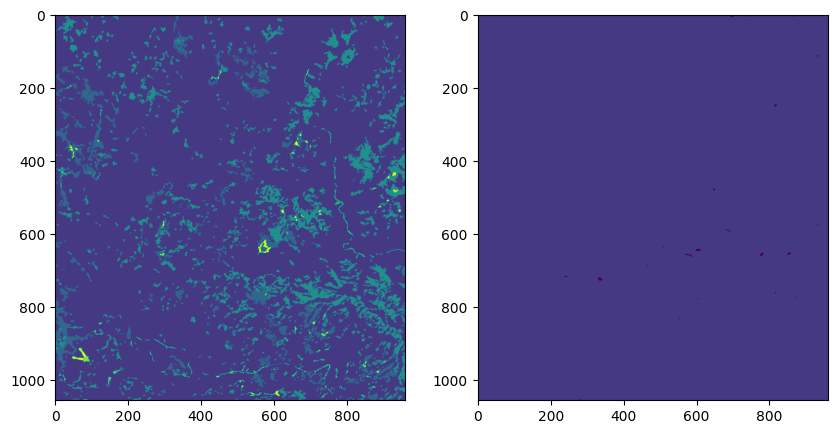

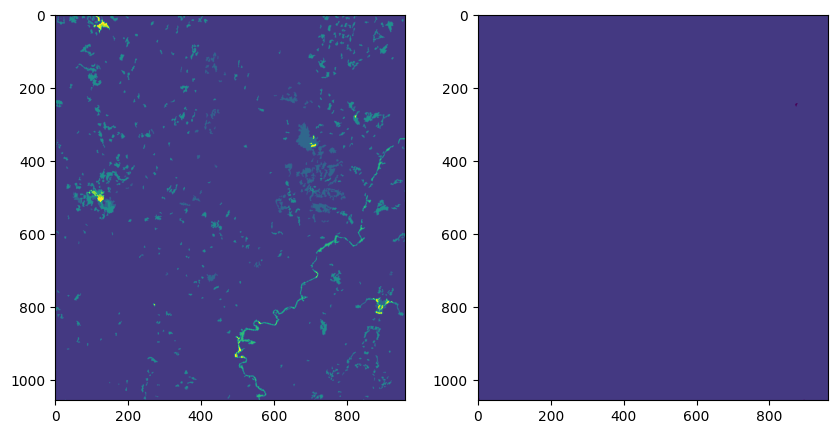

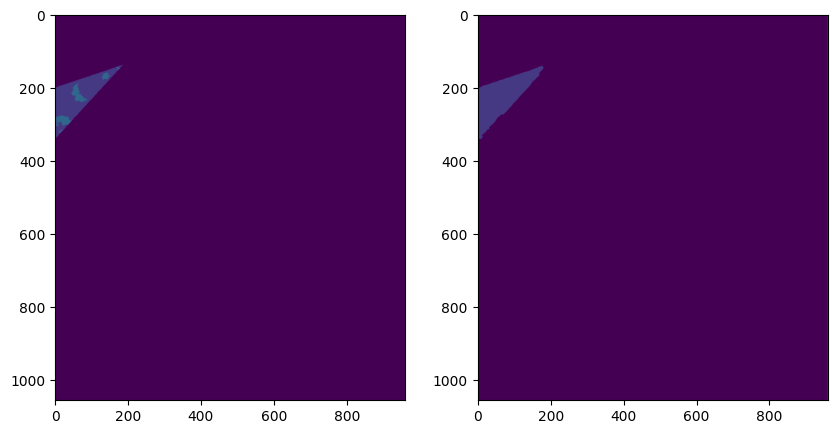

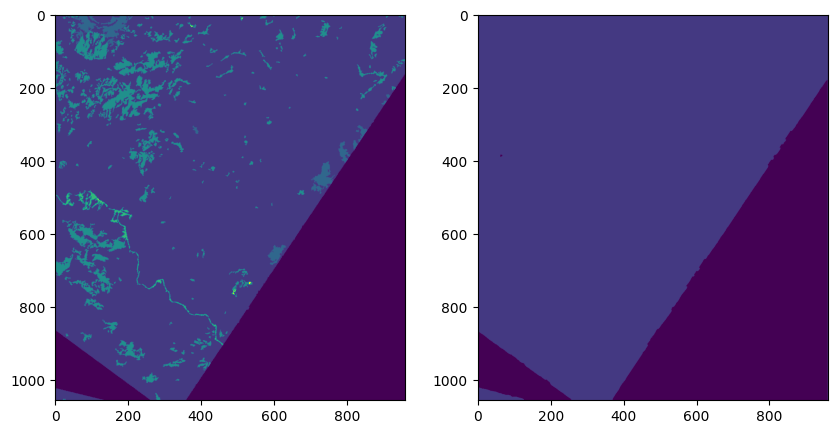

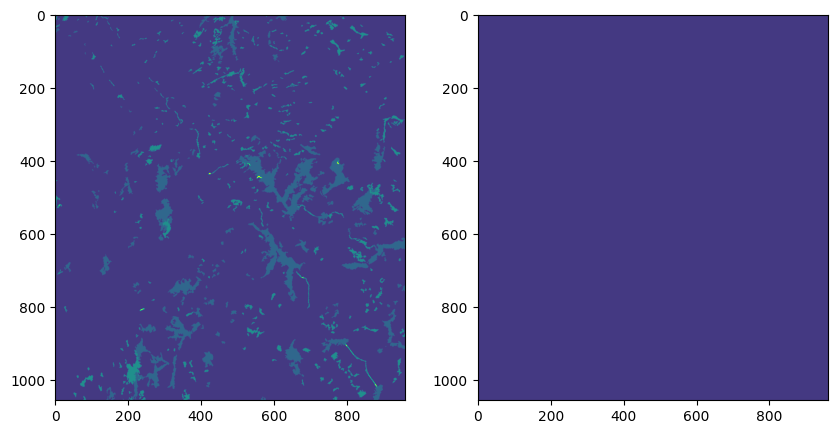

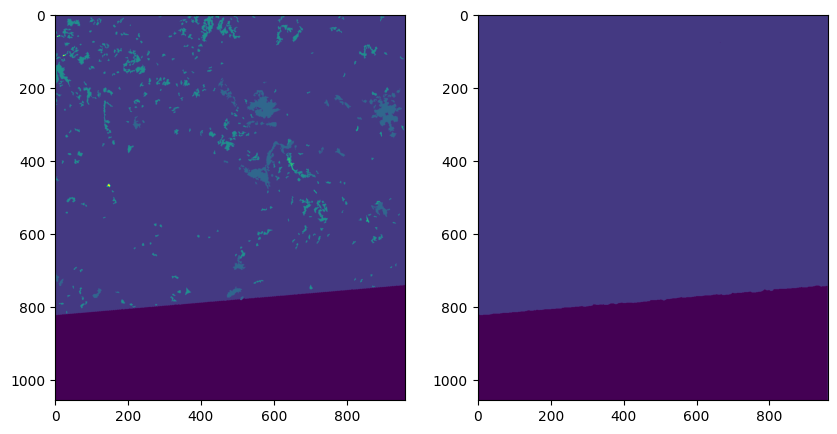

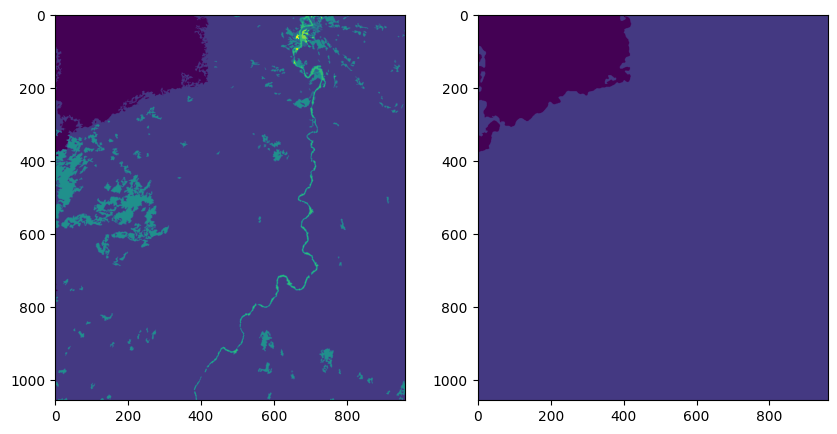

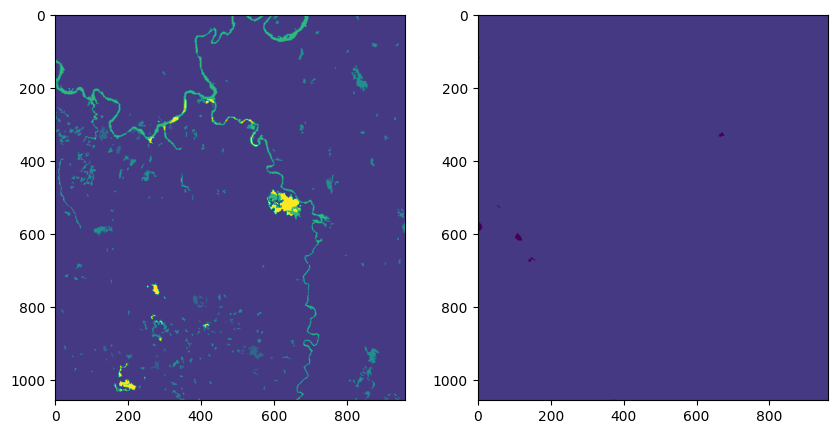

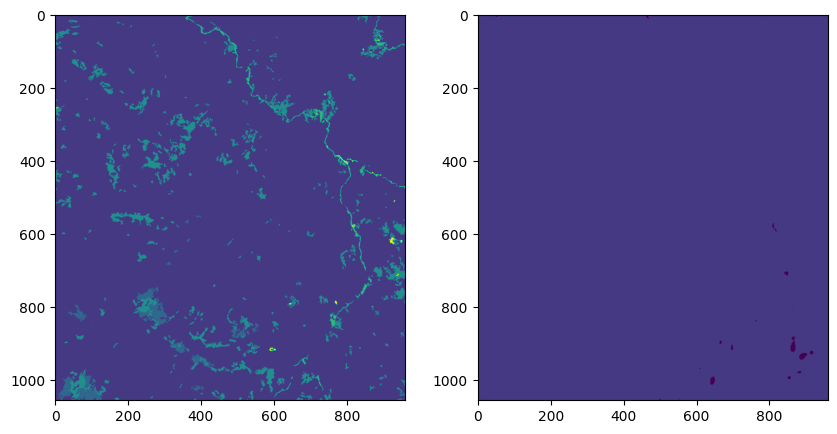

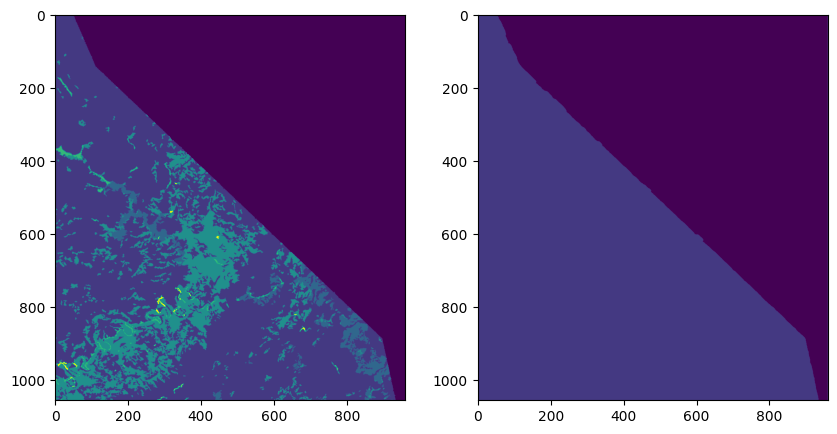

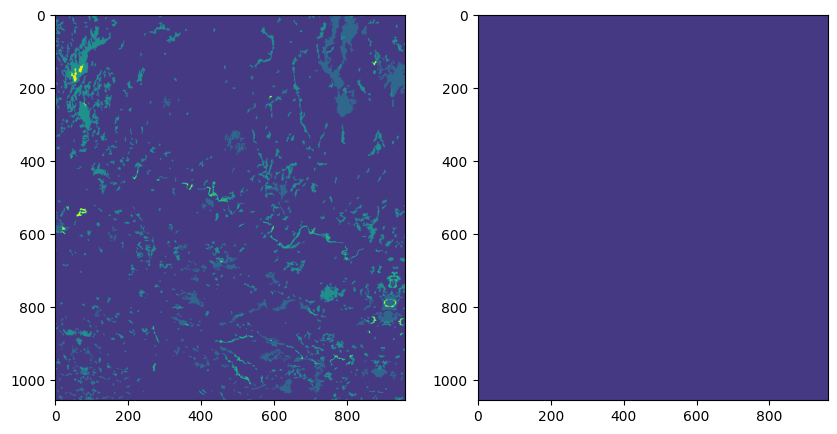

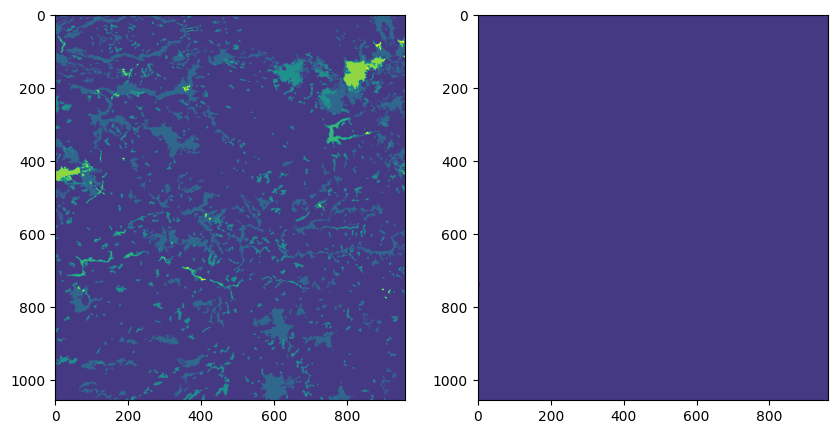

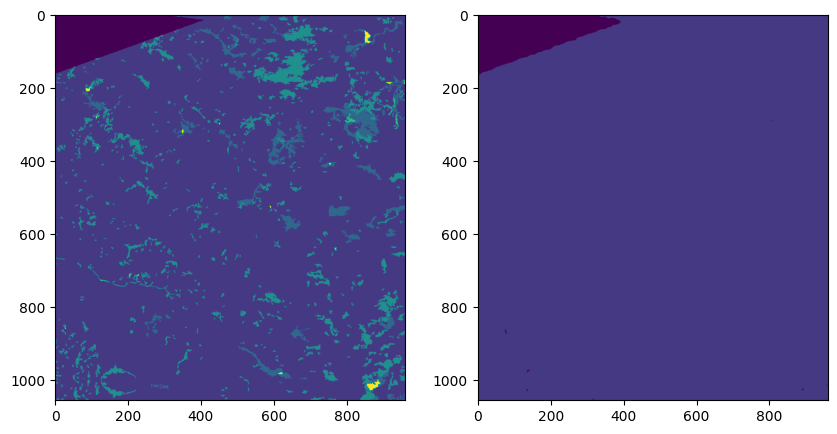

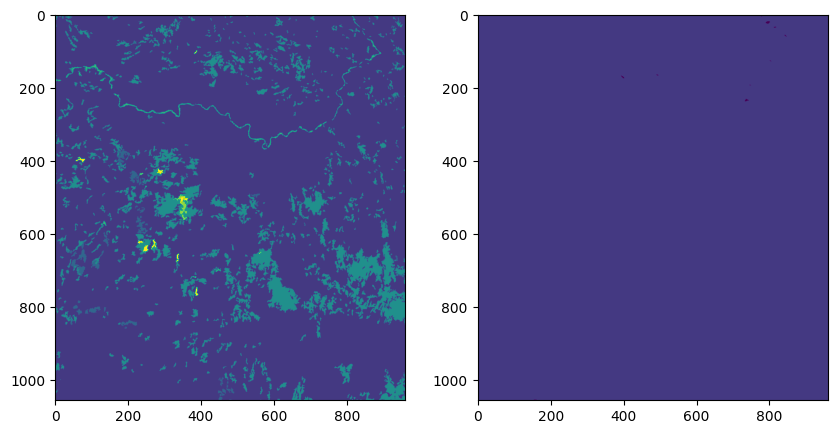

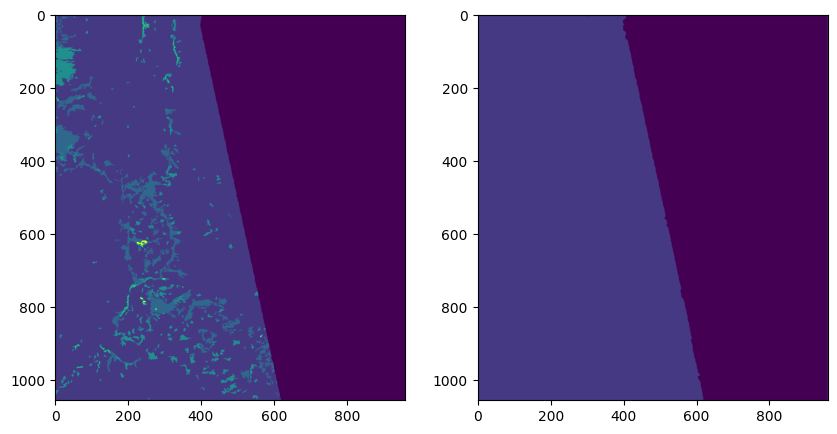

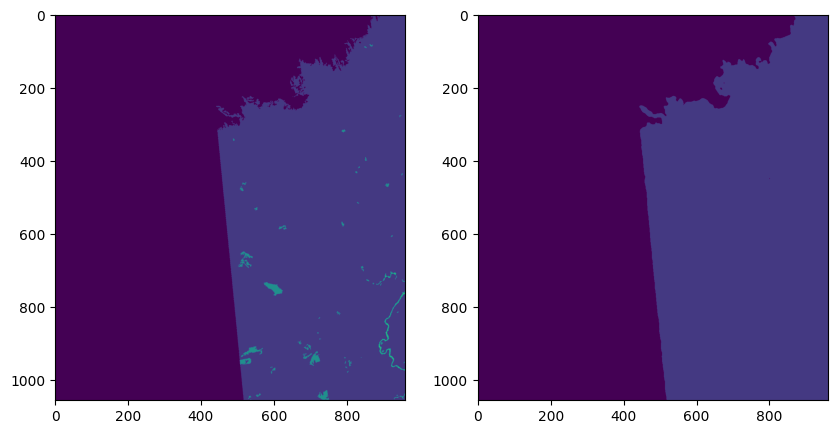

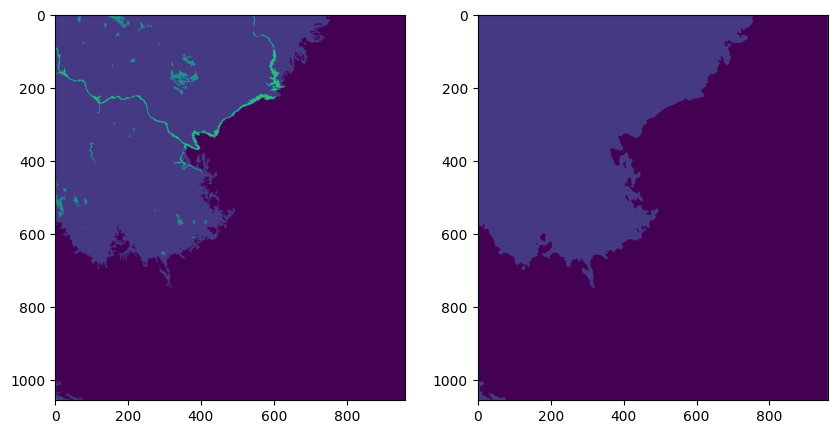

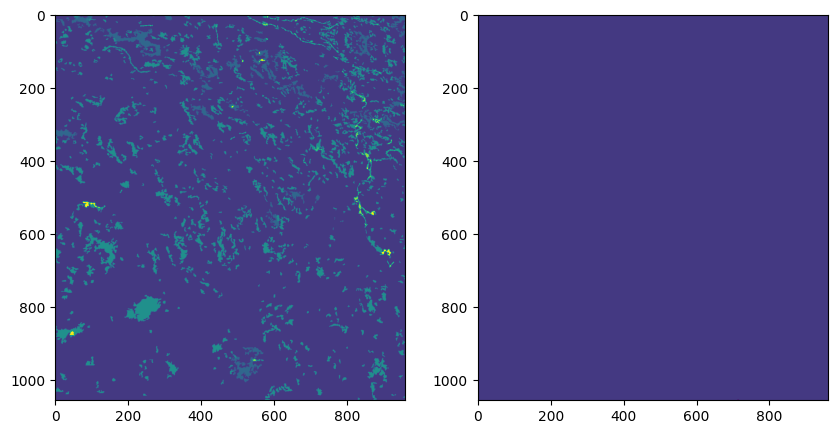

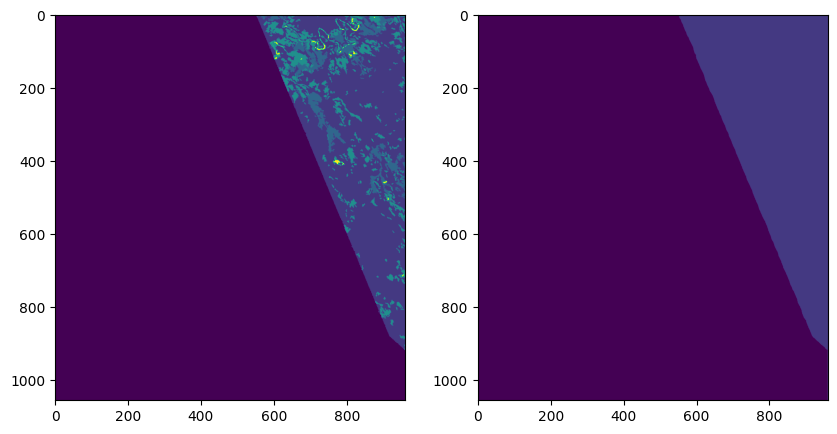

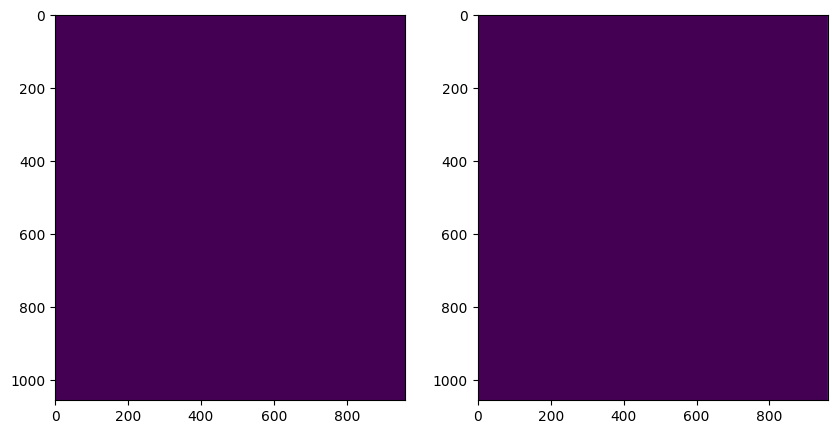

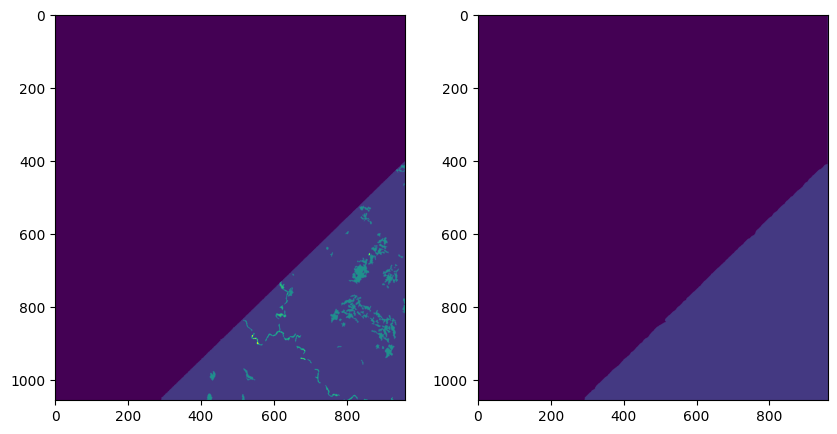

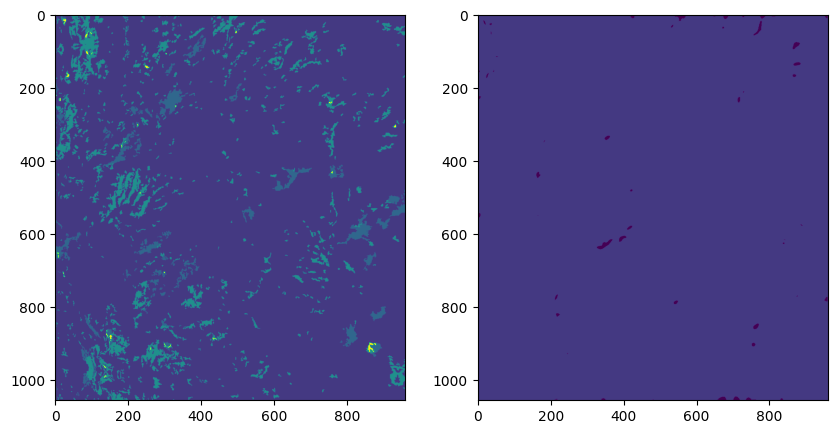

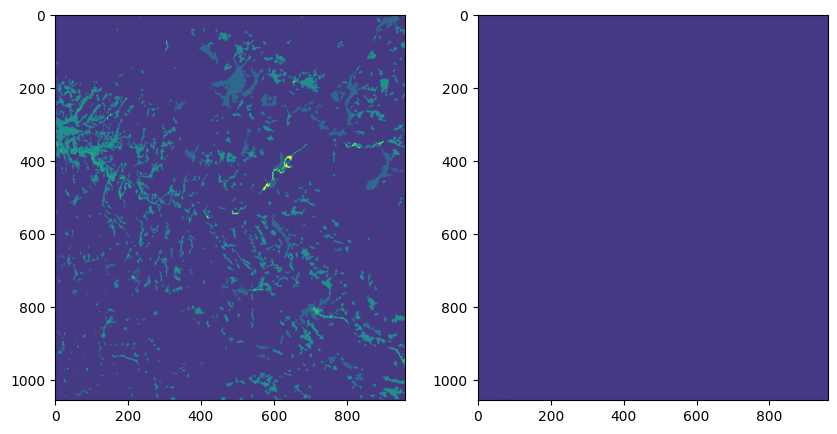

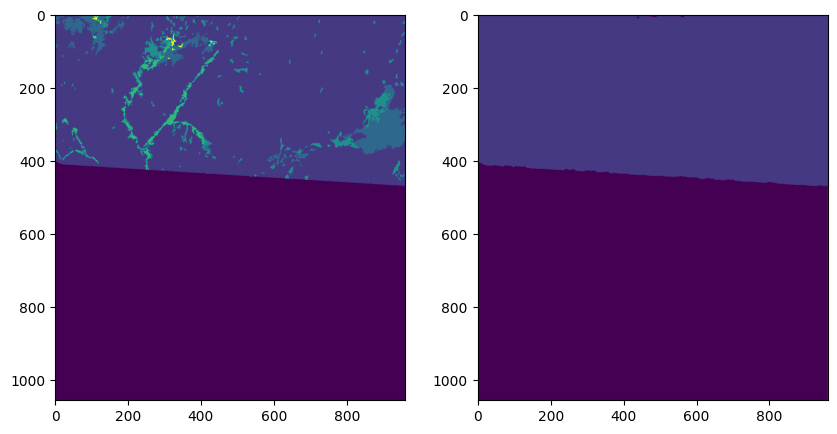

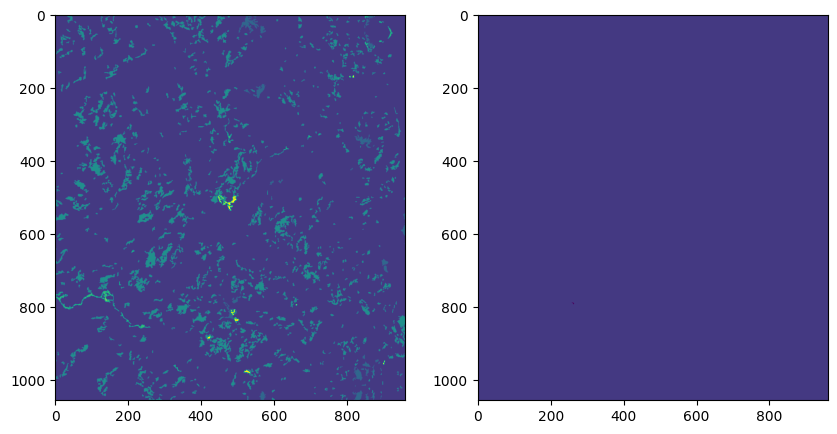

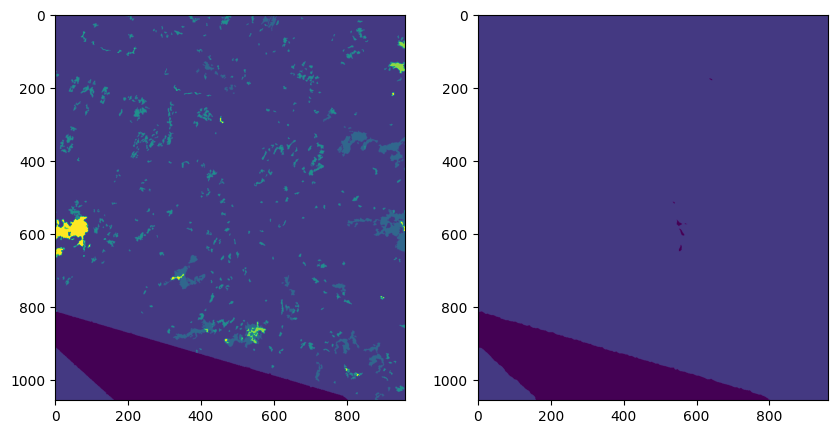

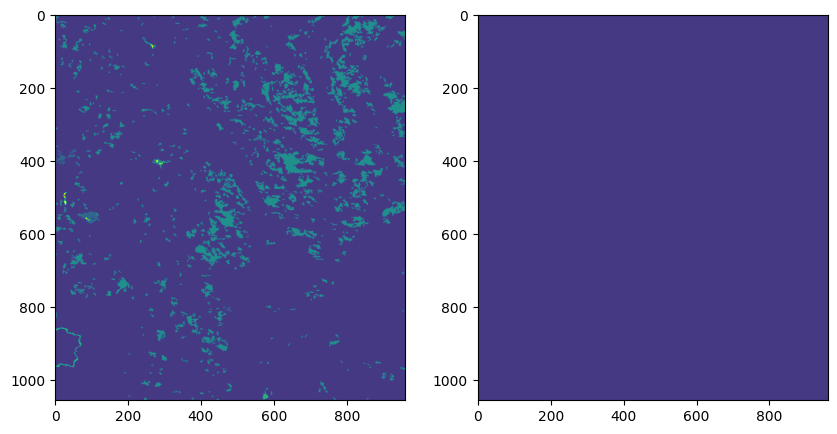

In [ ]:
for i in range(30):
    #yp = F.softmax(y, dim=1).max(dim = 1)[1][i].numpy(force = True)
    #yf = yb[i].numpy(force = True)

    vmax = 6 #max(np.max(yp),np.max(yf))
    vmin = 0 #min(np.min(yp),np.min(yf))
    _, ax = plt.subplots(1, 2, figsize=(10, 5))
    #ax[0].imshow(probabilities[i][4].numpy(force = True))
    ax[0].imshow(targs[i], vmax = vmax, vmin = vmin)#F.softmax(y, dim=1).max(dim = 1)[1][i].numpy(force = True), vmin = vmin, vmax = vmax)
    ax[1].imshow(predicted[i], vmax = vmax, vmin = vmin)
    #ax[1].imshow(F.softmax(preds[i], dim=0).max(dim = 0)[0])
    #ax[2].imshow(F.softmax(preds, dim=1)[0][i*2 +1])

In [ ]:
#learn.save(file = '/home/gomosak/Conafor/modelo', with_opt=True, pickle_protocol=2)

Path('/home/gomosak/Conafor/modelo.pth')

In [ ]:
model = load_learner('/home/gomosak/Conafor/modelo.pth', cpu = False)

In [ ]:
Learner.export()

In [ ]:
xb,yb = next(iter(db.train))
xb.shape, yb.shape

(torch.Size([1, 6, 1056, 960]), torch.Size([1, 1056, 960]))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
db

In [ ]:
y = pred#model(xb)

In [ ]:
y = fv.cast(y,fv.Tensor)
y.shape

torch.Size([1056, 960])

In [ ]:
probabilities = F.softmax(y, dim=1)
probabilities.shape

RuntimeError: "softmax_lastdim_kernel_impl" not implemented for 'Long'

In [ ]:
F.softmax(y, dim=1).max(dim = 1)[1].shape

torch.Size([1, 1056, 960])

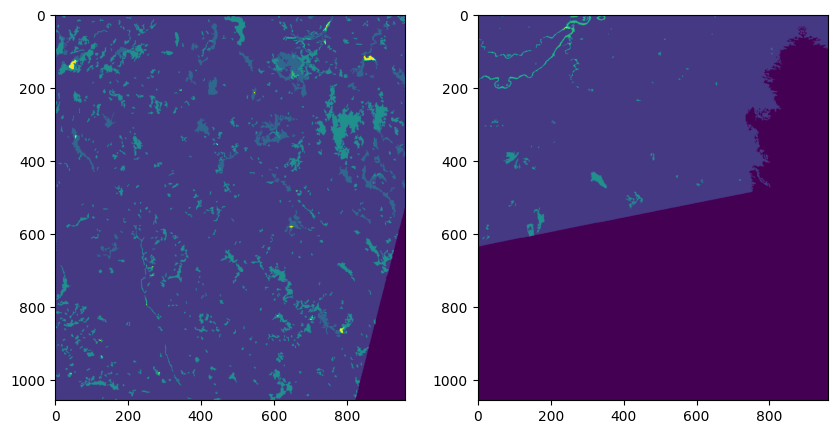

In [ ]:
#plt.imshow(probabilities[0][4].numpy(force = True))
for i in range(1):
    #yp = F.softmax(y, dim=1).max(dim = 1)[1][i].numpy(force = True)
    #yf = yb[i].numpy(force = True)

    vmax = 6 #max(np.max(yp),np.max(yf))
    vmin = 0 #min(np.min(yp),np.min(yf))
    _, ax = plt.subplots(1, 2, figsize=(10, 5))
    #ax[0].imshow(probabilities[i][4].numpy(force = True))
    ax[0].imshow(y)#F.softmax(y, dim=1).max(dim = 1)[1][i].numpy(force = True), vmin = vmin, vmax = vmax)
    ax[1].imshow(yb[i].numpy(force = True),vmin = vmin, vmax = vmax)

In [ ]:
i = 1

In [ ]:
np.unique(yb[i].numpy(force = True))

array([0, 1, 3, 4, 6])

In [ ]:
np.unique(F.softmax(y, dim=1).max(dim = 1)[1][i].numpy(force = True))

array([1])

In [ ]:
unique, counts = np.unique(yb[i].numpy(force = True), return_counts=True)

dict(zip(unique, counts))


{0: 17670, 1: 64346, 3: 20384}

In [ ]:
unique, counts = np.unique(F.softmax(y, dim=1).max(dim = 1)[1][i].numpy(force = True), return_counts=True)

dict(zip(unique, counts))

{0: 15441, 1: 86914, 2: 2, 3: 43}

In [ ]:
F.softmax(y, dim=1).max(dim = 1)[1][i].shape

torch.Size([320, 320])

In [ ]:
np.min(F.softmax(y, dim=1).max(dim = 1)[1][0].numpy(force = True))

0

In [ ]:
yb[1]

TensorMask([[1, 1, 1,  ..., 1, 1, 1],
            [1, 1, 1,  ..., 1, 1, 1],
            [1, 1, 1,  ..., 1, 1, 1],
            ...,
            [1, 1, 1,  ..., 1, 1, 1],
            [1, 1, 1,  ..., 1, 1, 1],
            [1, 1, 1,  ..., 1, 1, 1]], device='cuda:0')

In [ ]:
F.softmax(y, dim=1).max(dim = 1)[1][1][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

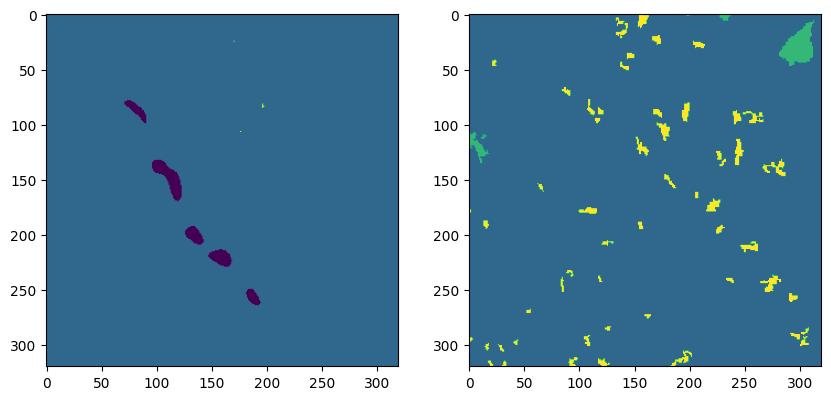

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
#ax[0].imshow(probabilities[i][4].numpy(force = True))
ax[0].imshow(F.softmax(y, dim=1).max(dim = 1)[1][1].numpy(force = True),vmin = 0, vmax = 3)
ax[1].imshow(yb[1].numpy(force = True), vmin = 0, vmax = 3)

In [ ]:
yb.shape

torch.Size([1, 320, 320])

In [ ]:
probabilities[0,:,95,10]

tensor([4.8682e-03, 9.6747e-01, 5.5517e-03, 2.0416e-02, 1.4847e-03, 1.0630e-04,
        1.0323e-04], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
F.softmax(y, dim=1).max(dim = 1)[1][0,95,10]

tensor(1, device='cuda:0')

In [ ]:
yb[0,0,0], yb[0,95,10],

(TensorMask(1, device='cuda:0'), TensorMask(1, device='cuda:0'))

In [ ]:
plt.imshow(yb[0].numpy(force = True))

TypeError: Invalid shape (7, 320, 320) for image data

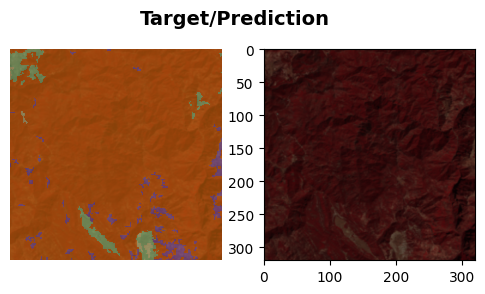

In [ ]:
learn.show_results()

In [ ]:
xb.shape

torch.Size([1, 6, 320, 320])

In [ ]:
pred = learn.predict(xb[0])

In [ ]:
pred

(TensorMask([[[-1.4060, -2.4079, -2.3634,  ..., -2.5370, -2.7180, -1.7341],
              [-2.2283, -3.3471, -2.9711,  ..., -3.3967, -3.9085, -2.7049],
              [-2.1011, -2.7683, -1.9807,  ..., -2.6219, -3.5125, -2.6099],
              ...,
              [-1.3813, -2.2430, -1.9122,  ..., -5.5122, -5.0719, -2.9545],
              [-1.9724, -3.1475, -3.0767,  ..., -5.1880, -4.9758, -2.9496],
              [-1.4192, -2.2372, -2.2386,  ..., -3.0370, -2.9216, -1.6290]],
 
             [[ 1.2724,  1.6444,  1.5729,  ...,  1.9037,  1.8469,  1.2158],
              [ 1.5239,  1.9836,  1.7952,  ...,  2.4451,  2.3307,  1.9246],
              [ 1.4260,  1.8662,  1.7924,  ...,  2.4663,  2.3391,  1.8540],
              ...,
              [ 2.3990,  3.4697,  3.4053,  ...,  0.8152,  0.8094,  0.6176],
              [ 2.1440,  3.1266,  2.9580,  ...,  0.7918,  0.9137,  0.7407],
              [ 1.8481,  2.3268,  2.1986,  ...,  0.7826,  0.9356,  0.8051]],
 
             [[-1.7403, -2.7438, -2.7840,  .

In [ ]:
pred[0].shape, pred[1].shape , pred[2].shape

(torch.Size([7, 320, 320]),
 torch.Size([7, 320, 320]),
 torch.Size([7, 320, 320]))

In [ ]:
pred[0].softmax(dim  = 0).shape

torch.Size([7, 320, 320])

In [ ]:
yrt = fv.cast(yb[0],fv.Tensor)

In [ ]:
maskrt = fv.cast(pred[0],fv.Tensor)

In [ ]:
yrt.shape

torch.Size([320, 320])

In [ ]:
maskrt.shape

torch.Size([6, 320, 320])

In [ ]:
a = loss(maskrt,yrt)
a

ValueError: Expected input batch_size (6) to match target batch_size (320).

In [ ]:
maskrt.shape

torch.Size([6, 320, 320])

In [ ]:
maskrt.softmax(dim = 0)[0].shape

torch.Size([320, 320])

In [ ]:
y1 = yrt.numpy(force = True)
y2 = maskrt.softmax(dim = 0).max(dim= 0)[0].numpy(force = True)

In [ ]:
y2.shape

(320, 320)

In [ ]:
y1.shape

(320, 320)

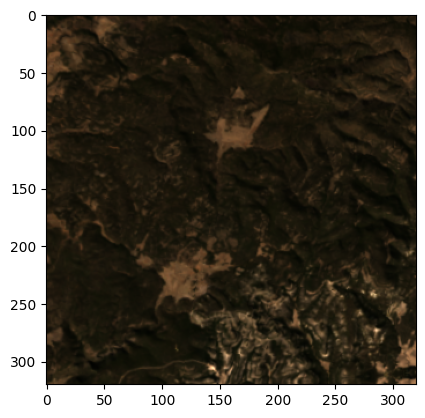

In [ ]:
xb[0].to('cpu').show(chnls=[2,1,0],bright=3.)

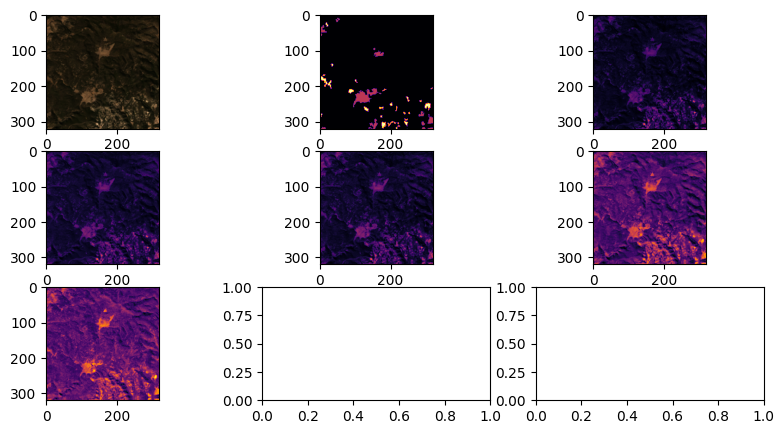

In [ ]:


# Configurar la figura y el eje
fig, ax = plt.subplots(3, 3, figsize=(10, 5))

# Plottear la imagen
xb[0].to('cpu').show(chnls=[2,1,0],bright=3., ctx=ax[0,0])
ax[0,1].imshow(y1, cmap='inferno')
ax[0,2].imshow(maskrt[0], cmap='inferno')
ax[1,0].imshow(maskrt[1], cmap='inferno')
ax[1,1].imshow(maskrt[2], cmap='inferno')
ax[1,2].imshow(maskrt[3], cmap='inferno')
ax[1,2].imshow(maskrt[4], cmap='inferno')
ax[2,0].imshow(y2, cmap='inferno')
#y2






# Mostrar la imagen
plt.show()

In [ ]:
np.unique(y1)

array([1, 3, 4, 6])

In [ ]:
np.unique(y2)

array([2, 3, 4])

In [ ]:
fv.accuracy(y1,y2)

TypeError: argmax() got an unexpected keyword argument 'dim'

In [ ]:
y2 = maskrt.max(dim = 0)#[1].numpy(force = True)

In [ ]:
y2

torch.return_types.max(
values=tensor([[0.2531, 0.2349, 0.2046,  ..., 0.3092, 0.3067, 0.2989],
        [0.2622, 0.2522, 0.2160,  ..., 0.2918, 0.2982, 0.2956],
        [0.2655, 0.2580, 0.2319,  ..., 0.2779, 0.2835, 0.2841],
        ...,
        [0.1958, 0.1919, 0.2012,  ..., 0.2403, 0.2376, 0.2667],
        [0.2449, 0.2342, 0.2245,  ..., 0.2221, 0.2501, 0.2758],
        [0.2426, 0.2453, 0.2324,  ..., 0.1972, 0.2332, 0.2583]]),
indices=tensor([[4, 4, 4,  ..., 3, 3, 3],
        [4, 4, 4,  ..., 3, 3, 3],
        [4, 4, 4,  ..., 3, 3, 3],
        ...,
        [4, 4, 4,  ..., 4, 3, 3],
        [4, 4, 4,  ..., 4, 3, 3],
        [4, 4, 4,  ..., 3, 3, 3]]))

In [ ]:
pred,targ = flatten_check(y2[1], yrt)
#return (pred == targ).float().mean()

In [ ]:
pred =pred.cuda()#, targ.device

In [ ]:
pred.device

device(type='cuda', index=0)

In [ ]:
(pred == targ).float().mean()

TensorBase(0.0073, device='cuda:0')

In [ ]:
pred.shape

torch.Size([102400])

In [ ]:
targ.shape

torch.Size([102400])

In [ ]:
y1.shape

(320, 320)

In [ ]:
y2.shape

(320, 320)

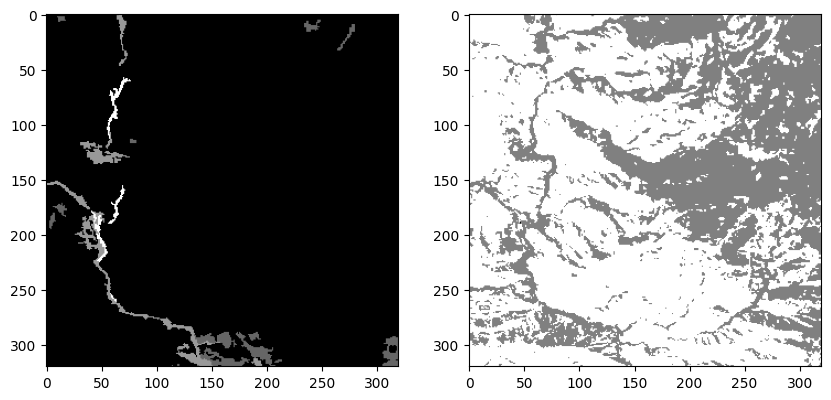

In [ ]:
# Configurar la figura y el eje
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plottear la imagen
ax[0].imshow(y1, cmap='gray')
ax[1].imshow(y2, cmap='gray')





# Mostrar la imagen
plt.show()

In [ ]:
xb.show

<bound method MSTensorImage.show of MSTensorImage: torch.Size([10, 6, 320, 320])>

In [ ]:
def seg_accuracy(yp,y):
	return fv.accuracy(yp,y)

In [ ]:
yp = torch.randint(0,2,(3,3))
yp

tensor([[0, 0, 1],
        [0, 0, 1],
        [1, 1, 0]])

In [ ]:
y = torch.rand(3,3,3)
y

tensor([[[0.2565, 0.6907, 0.7103],
         [0.3753, 0.3085, 0.1853],
         [0.0266, 0.1221, 0.6481]],

        [[0.9933, 0.7475, 0.5510],
         [0.3362, 0.3203, 0.5114],
         [0.4611, 0.6812, 0.8992]],

        [[0.6590, 0.8573, 0.7238],
         [0.7835, 0.6783, 0.6853],
         [0.8935, 0.5322, 0.4509]]])

In [ ]:
seg_accuracy(y,yp)

TensorBase(0.4444)

In [ ]:
predd = y.argmax(dim=-1)

In [ ]:
predd == yp

tensor([[False,  True, False],
        [ True, False, False],
        [ True, False,  True]])

In [ ]:
flatten_check(y.argmax(dim=-1), yp)

(TensorBase([2, 0, 2, 0, 2, 2, 1, 0, 0]),
 TensorBase([0, 0, 1, 0, 0, 1, 1, 1, 0]))

In [ ]:
flatten_check(inp.argmax(dim=axis), targ)
return (pred == targ).float().mean()

In [ ]:
fv.accuracy??

Signature: fv.accuracy(inp, targ, axis=-1)
Source:   
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()
File:      ~/scrapMaps/lib/python3.10/site-packages/fastai/metrics.py
Type:      function